Just a first draft, delete, modify as you want 

**TODO**: add anchors for easy navigation, remove some dupplicated code

<a id="0"></a> <br>
## Contents
* [Q1: How impactful is the team surrounding the director on the success of a movie?](#first)
<br>
<br>
<br>
* [Q2: To what extent does the director’s choice of movie genre affect the success of the movie?](#second)
<br>
<br>
<br>
* [Q3: What is the impact of the director’s character choices on the success of the movie?](#third)
    * [3.1 - What types of characters do successful directors choose?](#thirdone)
    * [3.2 - How diverse are the directors in their character choices?](#thirdsecond)
    * [3.3 - Can we find very successful directors that always use the same type of characters or others that vary a lot in their persona choices?](#thirdthird)
    * [3.4 - In definitive, how does this impact the movie’s success?](#thirdfourth)

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import pickle
import gc

from helpers.readers import prepare_dataframes, read_dataframe_parquet, read_dataframe
from helpers.readers import save_parquet_to_generated, save_dict_to_generated, load_dict_from_generated
from helpers.utils import PALETTE_D, PALETTE_C

#### Q1

In [ ]:
#Basic imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from collections import Counter

#Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize

#Import for interactive plots
import plotly.graph_objects as go
from ipywidgets import interact, widgets

#Networkx imports
import networkx as nx
from networkx import community
from networkx.algorithms import bipartite


#Imports for stats
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import MinMaxScaler

#Custom readers import
from helpers.readers import read_dataframe
from helpers.utils import PALETTE_D, PALETTE_C

<a class="anchor" id="first"></a>
# Q1:  How impactful is the team surrounding the director on the success of a movie?

[Back to Table of Contents](#Contents)

To answer to this question, we need additional information than what we already have in the `movies` & `directors` dataframe. Namely, the `imdb_people` and `imdb_principals` dataframe are of interest here.

- `imdb_people` contains birth/death years, primary professions and famous titles for ~12M people in the IMDb database

- `imdb_principals` contains the principal (max 10 per movie) people that have played in movies in the IMDb database (roughs out to ~58M rows)


They will thus be used to extract information about people that worked on the movies we selected. Their primary professions, the number of movies they played in, the potential nature of the roles they played in each movie (once actor, once writer, etc.)

We first retrieve 'reduce' these two dataframes to only contain information about the movies we decided to keep:

In [ ]:
imdb_crew = read_dataframe_parquet("imdb/crew")
imdb_info = read_dataframe_parquet("imdb/movies")
imdb_ratings = read_dataframe_parquet(name='imdb/ratings')

movies = read_dataframe_parquet("cmu/movies")
movies = movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')


movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

# vectorized
def compute_score(df):
    df['score'] = np.log10(df['votes']) * df['rating']
    return df

movies = compute_score(movies)
movies = movies.set_index('tconst')

In [6]:
save_parquet_to_generated("q1_movies", movies)

In [7]:
directors = read_dataframe_parquet("q1/directors")

nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28478 directors.


### to unmarkdown?
%%time
imdb_info = read_dataframe_parquet(name='imdb/movies')
imdb_ratings = read_dataframe_parquet(name='imdb/ratings')
movieLens_movies = read_dataframe_parquet(name='movieLens/movies')
movieLens_ratings = read_dataframe_parquet('movieLens/ratings')

imdb_crew = read_dataframe_parquet(name='imdb/crew')
imdb_people = read_dataframe_parquet(name='imdb/names')
imdb_principals = read_dataframe_parquet(name='imdb/principals')

#directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
#directors = directors.set_index('nconst')

In [8]:
#```python
def matching_selected_people(imdb_people,imdb_principals,movies) : 

    """
    This function filters the IMDb dataframes for people that worked on the selected movies.

    Args :
        imdb_people : The IMDb 'basic' dataframe. Contains information about people, f.i the movies they are known most for.
        imdb_principals : The IMDb 'principals' dataframe. Contains information about the main cast of the IMDb movies, such as their name, job in the movie, role, etc.
        movies : The dataset of selected movies

    Returns :
        matched_imdb_people : The IMDb 'basic' dataframe matched for our selected movies
        jobs_principal_people : The IMDb 'principals' dataframe matched for our selected movies.
    """

    #Exploding the imdb people dataframe to have all films played by people in the dataframe
    imdb_people_exploded = imdb_people.copy()
    imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
    imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])

    #Merging operations to retrieve the mapped information
    merged_ipe = pd.merge(imdb_people_exploded,movies, how='inner', left_on='knownForTitles', right_on='tconst')
    unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')
    matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
    tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
    jobs_principal_people = pd.merge(tmp_principal_people,movies,on='tconst',how='inner')[['tconst','nconst','category','job']]

    return(matched_imdb_people,jobs_principal_people)


imdb_people = read_dataframe_parquet(name='imdb/names')
imdb_principals = read_dataframe_parquet(name='imdb/principals')

matched_imdb_people,jobs_principal_people = matching_selected_people(imdb_people,imdb_principals,movies)

from helpers.readers import save_parquet_to_generated
save_parquet_to_generated("q1_matched_imdb_people",matched_imdb_people)
save_parquet_to_generated("q1_jobs_principal_people",jobs_principal_people)
#```

In [9]:
# shortcut
matched_imdb_people = read_dataframe_parquet("q1/matched_imdb_people")
jobs_principal_people = read_dataframe_parquet("q1/jobs_principal_people")

In [10]:
#```python
def get_all_known_roles(matched_principal,all_matched_people) : 
    """
    Adds additional movies that people present in the matched_principal dataframe passed as argument have played a certain role in.

    Args:
    matched_principal: The IMDb 'principal' dataframe matched for our selected movies. Contains
                       information about the 'principal' crew of each movie.

    all_matched_people: The IMDb 'people' dataframe matched for our selected movies. Contains
                        personal information about people in the film industry.

    Returns:
    enhanced_matched_principal: The all_matched_people dataframe passed as argument, with an additional column
                                containing any additional roles found in the matched_principal
                                dataframe. 
    """
    roles_collected = {}

    # Iterating over matched_principal to collect roles for each person
    for _, row in tqdm(matched_principal.iterrows(),total=len(matched_principal),desc='Getting all known roles of our matched people'):
        nconst = row['nconst']
        tconst = row['tconst']
        
        if nconst not in roles_collected:
            roles_collected[nconst] = set()

        roles_collected[nconst].add(tconst)

    # Updating enhanced_matched_principal with the collected roles
    enhanced_matched_principal = all_matched_people.copy()
    enhanced_matched_principal['all_known_roles'] = enhanced_matched_principal['nconst'].map(lambda x: ','.join(map(str, roles_collected.get(x,[]))))

    return enhanced_matched_principal

mip_enhanced = get_all_known_roles(jobs_principal_people,matched_imdb_people)
save_parquet_to_generated("q1_mip_enhanced",mip_enhanced)
#```

Getting all known roles of our matched people: 100%|████████████████████████| 618126/618126 [00:32<00:00, 19156.52it/s]


In [11]:
# shortcut
mip_enhanced = read_dataframe_parquet("q1/mip_enhanced") 

In [12]:
#```python
tqdm.pandas(desc='Adding the directed movies to each of our directors')

def get_directed_movies(director_row, movies_df):
    """
    Returns a list of the IMDb IDs of the movie directed by a certain director.

    Args :
        director_row : A row of the 'directors' dataframe, containing information about
        movies_df : The dataframe containing the movies information
    """
    curr_dir_id = director_row.name
    directed_movies = ','.join(movies_df[movies_df.directors.str.contains(curr_dir_id)].index)
    return directed_movies

def add_directed_movies(directors_df, movies_df):
    """
    Returns a modified version of the directors_df dataframe, with a new column indicating all the movies directed in the movies_df dataframe, for each director.

    Args :
        directors_df : The dataframe containing the director's information
        movies_df : The dataframe containing the movies information

    Returns :
        directors_df : The original dataframe with the added column
    """
    directors_df['directed_movies'] = directors_df.progress_apply(lambda row: get_directed_movies(row, movies_df), axis=1)
    return directors_df

enhanced_directors_df = add_directed_movies(directors, movies[['directors']])
save_parquet_to_generated("q1_enhanced_directors",enhanced_directors_df)
#```

Adding the directed movies to each of our directors: 100%|███████████████████████| 28478/28478 [21:32<00:00, 22.03it/s]


In [13]:
# shortcut
enhanced_directors_df = read_dataframe_parquet("q1/enhanced_directors") 

In [14]:
#```python
def counting_directors_collaborations(directors_df, matched_imdb_people):
    """
    Returns a dictionnary containing the number of collaborations between directors and different crew members, for the movies selected.

    Args :
    directors_df : A dataframe containing information about directors. it must contain at least the two following columns : 'nconst', the personal
                   IMDb ID of the director, and 'directed_movies' which they have directed
    
                   
    matched_imdb_people : A dataframe containing personal information about people that have worked on movies that we decided to retain. Must also contain
                          the 'nconst' and 'knownForTitles' columns.
    
    """
    # Create a mapping of titles to people : For each title, we create a mapping which basically adds, for each movie, all the people we know have played some role in the movie
    title_to_people = defaultdict(set)
    for _, person_row in tqdm(matched_imdb_people.iterrows(),total=len(matched_imdb_people),desc='Mapping titles to people'):
        person_id = person_row['nconst']
        known_for_titles = person_row['knownForTitles']
        all_known_roles = person_row['all_known_roles']

        known_for_titles = known_for_titles.split(',') if isinstance(known_for_titles,str) else []
        all_known_roles = all_known_roles.split(',') if isinstance(all_known_roles,str) else []

        unique_movies = set(filter(None, known_for_titles + all_known_roles))
        #print(person_id,unique_movies)
        for title in unique_movies:
                title_to_people[title].add(person_id)

    collaboration_counts = {}
    #Using the mapping, build the dictionnary of collaborations.
    for _, row in tqdm(directors_df.iterrows(),total=len(directors_df), desc='Creating the dictionnary of collaborations'):
        director_ids = set(row.name.split(',')) if isinstance(row.name, str) else set()
        directed_titles = set(row['directed_movies'].split(',')) if isinstance(row['directed_movies'], str) else set()

        for director_id in director_ids:
            if director_id not in collaboration_counts:
                collaboration_counts[director_id] = {}

            for title in directed_titles:
                collaborators = title_to_people[title] - {director_id}  # To remove the director from collaborators
                for collaborator in collaborators:
                    if collaborator not in collaboration_counts[director_id]:
                        collaboration_counts[director_id][collaborator] = 1
                    else:
                        collaboration_counts[director_id][collaborator] += 1

    return collaboration_counts

collab_counts = counting_directors_collaborations(enhanced_directors_df,mip_enhanced)

save_dict_to_generated("q1_collab_counts", collab_counts)
#```

Creating the dictionnary of collaborations: 100%|██████████████████████████████| 28478/28478 [00:07<00:00, 4003.82it/s]


In [15]:
collab_counts = load_dict_from_generated("q1_collab_counts")

---
### General overview of movie crews - How does the number of people working on the movies impact the success of the movies & directors ?

Let's see how many different people each director has worked with, without looking at if they collaborated a lot with the same people at first :

In [17]:
director_collaborators = []

for director, collaborations in collab_counts.items():
    num_collaborators = len(collaborations)
    director_collaborators.append({'Director': director, 'NumCollaborators': num_collaborators})

collab_counts_df = pd.DataFrame(director_collaborators)

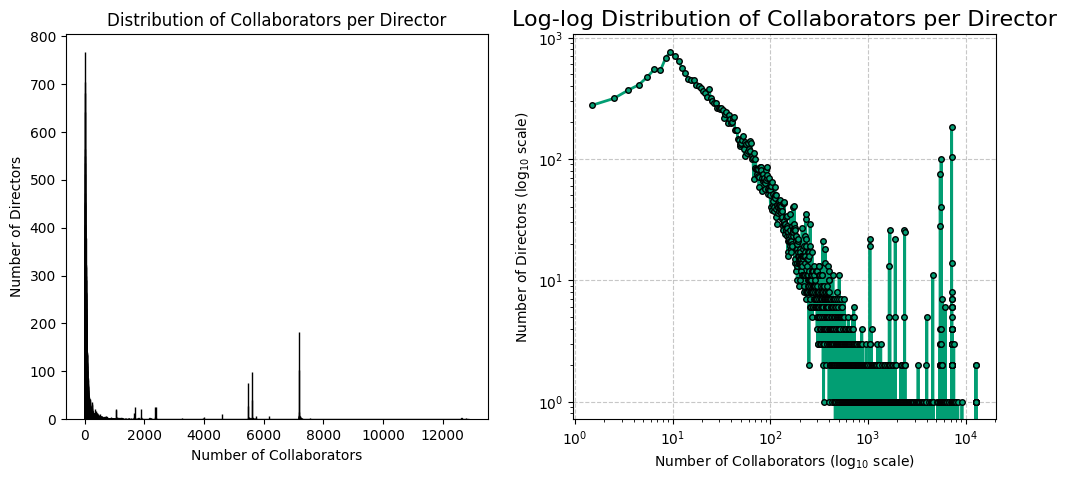

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2), edgecolor='black',color=PALETTE_D[1])
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Directors')
plt.title('Distribution of Collaborators per Director')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Number of Collaborators (log$_{10}$ scale)')
plt.ylabel('Number of Directors (log$_{10}$ scale)')
plt.title('Log-log Distribution of Collaborators per Director', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.tight_layout()
plt.show();

We have a minority of directors that directed a huge number of films and thus had a huge number of collaborations throughout their career.
Let's see if this behaviour reproduces for the size of the movie crew :

In [19]:
#```python
def get_movie_crew_size(movies,matched_people) :
    """ 
    Retrieves the movie crew size for selected movies.

    Args : 
        movies : The dataframe containing information about our selected movies,
        matched_people : The IMDb 'basics' dataframe mapped for the people in our selected movies only.

    Returns :
        final_movies : A copy of the 'movies' dataframe passed as argument with an additional column containing the crew size of the movie.
    """
    #Retrieving all roles played by the individuals of the matched_people dataframe, taking the union on both to not count a movie twice
    crew = matched_people.copy()
    crew['knownForTitles'] = crew['knownForTitles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    crew['all_known_roles'] = crew['all_known_roles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    roles_union_df = crew[['knownForTitles', 'all_known_roles']].apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)

    # Appropriate merges to return a modified version of the 'movies' dataframe
    roles_union_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_union_df})
    roles_union_df = roles_union_df.explode('roles_union')
    merged_df = pd.merge(movies, roles_union_df, left_index=True, right_on='roles_union')
    crew_sizes = pd.DataFrame(merged_df.groupby('roles_union')['nconst'].nunique())
    crew_sizes.rename(columns={'nconst': 'crew_size'},inplace=True)
    final_movies = pd.merge(movies,crew_sizes,left_index=True, right_index=True, how='left')

    return final_movies

movies_wcs = get_movie_crew_size(movies,mip_enhanced)
save_parquet_to_generated("q1_movies_wcs", movies_wcs)
#```

In [20]:
movies_wcs = read_dataframe_parquet("q1/movies_wcs")

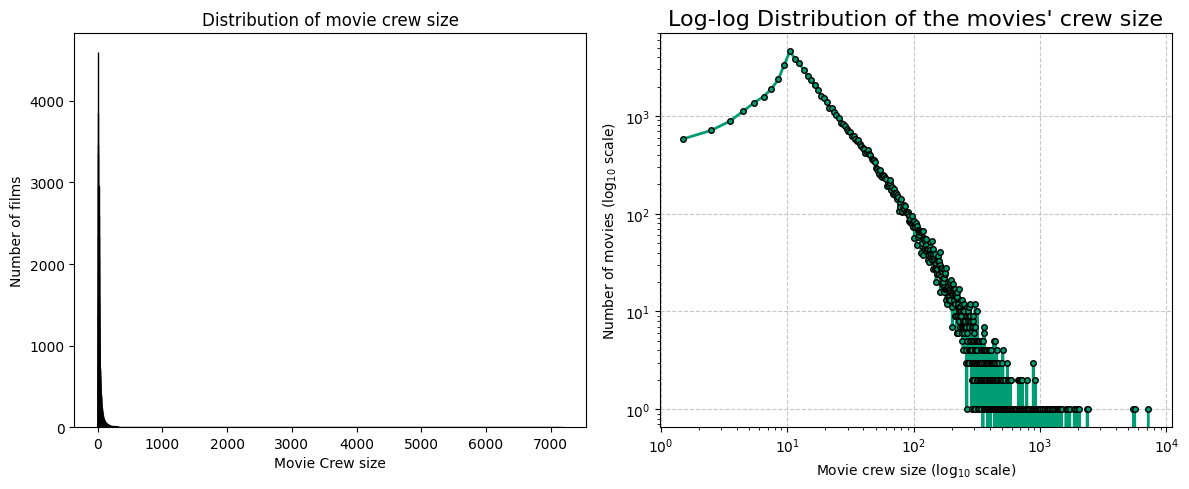

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2), edgecolor='black')
plt.xlabel('Movie Crew size')
plt.ylabel('Number of films')
plt.title('Distribution of movie crew size')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Movie crew size (log$_{10}$ scale)')
plt.ylabel('Number of movies (log$_{10}$ scale)')
plt.title('Log-log Distribution of the movies\' crew size', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

How are our movie scores distributed?

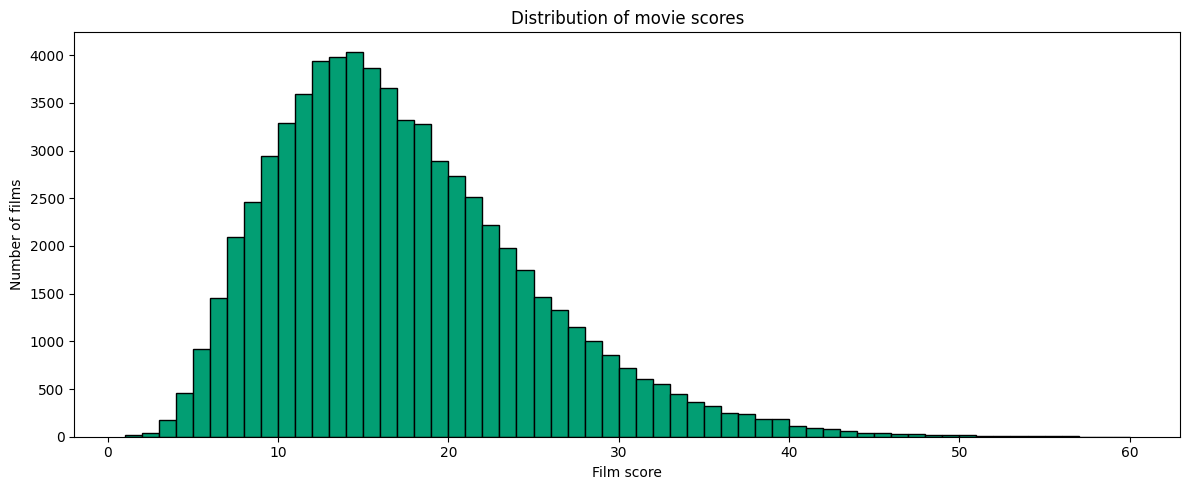

In [22]:
plt.figure(figsize=(12, 5))
plt.hist(movies['score'], bins=range(1, int(max(movies['score'])) + 2), color=PALETTE_D[1], edgecolor='black')
plt.xlabel('Film score')
plt.ylabel('Number of films')
plt.title('Distribution of movie scores')
plt.tight_layout()
plt.show()

Skewed, but not a power law. <br>
Let us thus first see how the movie crew size is linked to the movie score:

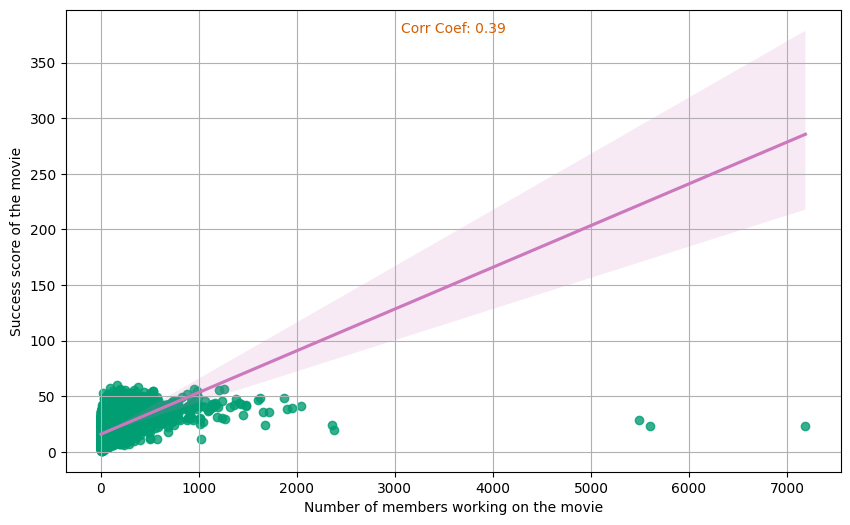

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wcs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wcs['crew_size'].corr(movies_wcs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

A few number of outliers with huge movie crewsizes : let's remove them to keep some reasonable crew sizes.

In [24]:
movies_wscs = movies_wcs[movies_wcs['crew_size'] < 3000]

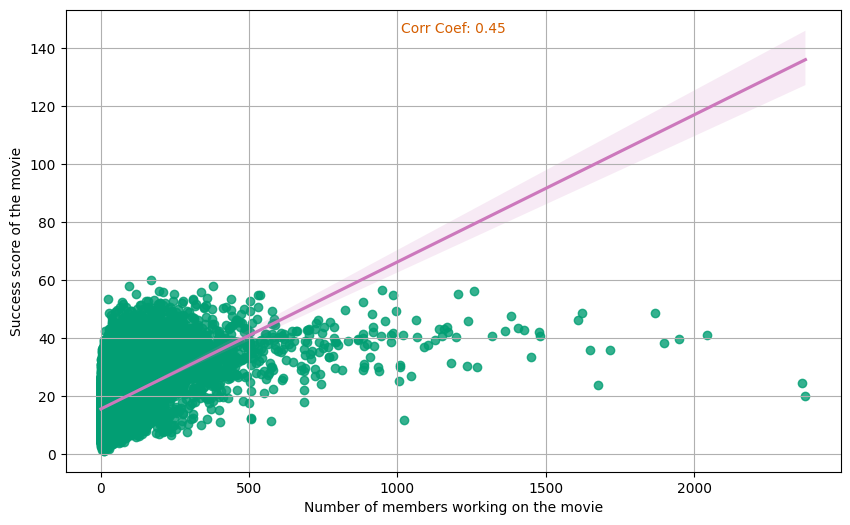

In [25]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wscs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wscs['crew_size'].corr(movies_wscs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

Difficult to assess the meaningfulness of the correlation between the size of the movie crew and the score of the movie. Let's display our first 10 movies in terms of score :

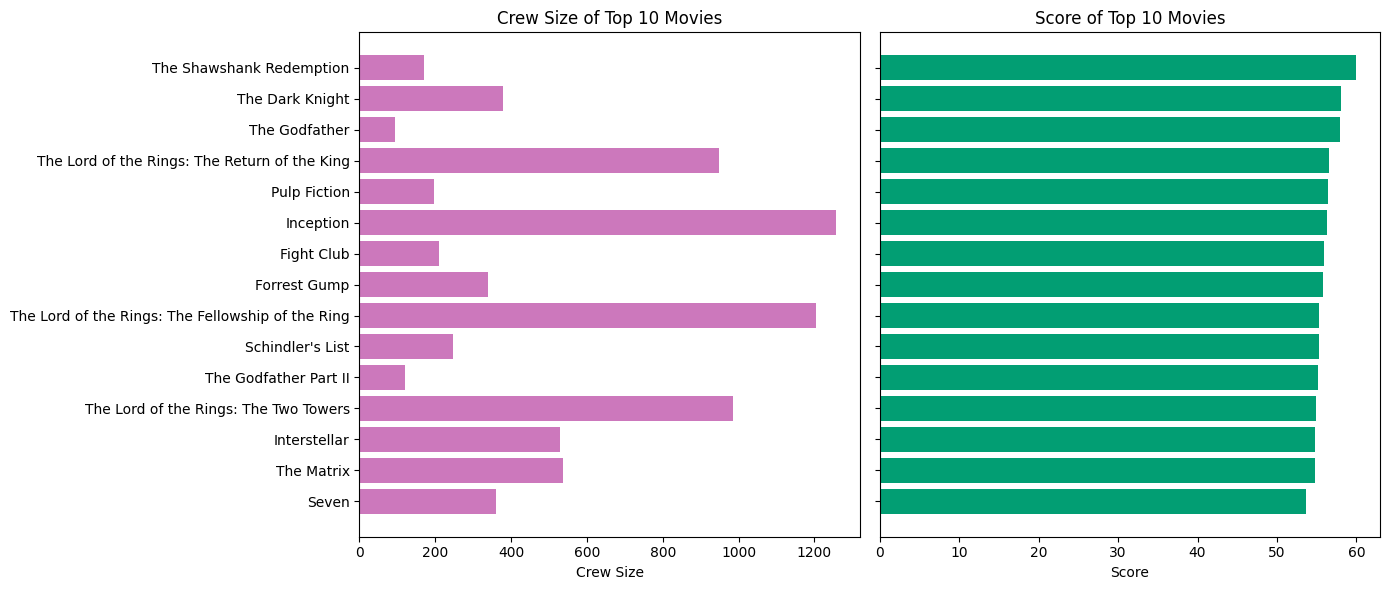

In [26]:
top_10_movies = movies_wscs.sort_values(by='score', ascending=False).head(15)
top_10_movies = top_10_movies.sort_values(by='score', ascending=True)

top_10_movies = top_10_movies.head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot 1: Crew Size
ax1.barh(top_10_movies['title'], top_10_movies['crew_size'], color= PALETTE_D[0])
ax1.set_xlabel('Crew Size')
ax1.set_title('Crew Size of Top 10 Movies')

# Barplot 2: Score
ax2.barh(top_10_movies['title'], top_10_movies['score'], color=PALETTE_D[1])
ax2.set_xlabel('Score')
ax2.set_title('Score of Top 10 Movies')

plt.tight_layout()
plt.show()

We can just see that even amongst our most popular movies, we have the LOTR films & inception with a huge number of people who are credited, but actually the Godfather has a rather small crew size when compared to the latter. <br>
If the impact on a certain movie is thus not really established, Let's try to see how the directors surround themselves for their movies : do they always have a huge number of people around them ?

### bug zone start

In [27]:
enhanced_directors_df['directed_movies'] = enhanced_directors_df['directed_movies'].apply(lambda x: ','.join(x))

In [28]:
oui = enhanced_directors_df.copy(deep=True)

oui['directed_movies'] = oui['directed_movies'].apply(lambda x: str(x).split(','))

# Explode the lists to separate rows for each movie ID
directors_exploded = oui.explode('directed_movies')

merged_df = pd.merge(directors_exploded, movies_wcs, how='left', left_on='directed_movies', right_index=True)

# Filter for rows where the director has directed at least 3 movies
filtered_directors = merged_df.groupby('nconst').filter(lambda x: x['directed_movies'].nunique() >= 3)

# Calculate the average crew size for each director
average_crew_size = pd.DataFrame(filtered_directors.groupby('nconst')['crew_size'].mean())

average_crew_size.rename(columns={'crew_size' : 'avg_crew_size'},inplace=True)

enhanced_directors_df = pd.merge(enhanced_directors_df,average_crew_size,how='left',left_index=True,right_index=True)

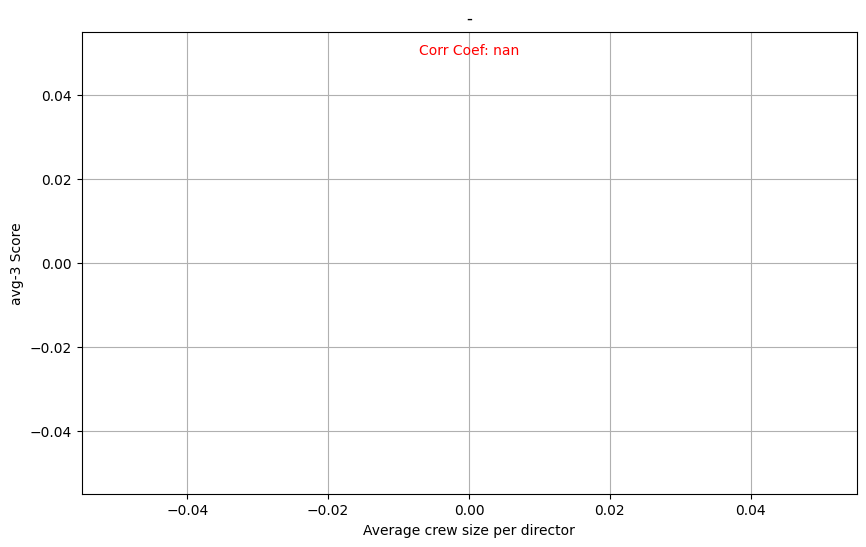

In [29]:
tmp_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3'])
tmp_df[['avg_crew_size', 'avg-3']] = tmp_df[['avg_crew_size', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=tmp_df, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = tmp_df['avg_crew_size'].corr(tmp_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew size per director')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

Interesting behaviour : seems like for averages inferior to a certain size there is a correlation between avg-3 score of the director and his/her average crew size but this is unbalanced when taking the movies superior to a certain size. Let's separate the directors in two to see how the two 'director' populations behave :

In [ ]:
large_crew_directors = tmp_df[tmp_df['avg_crew_size'] >= 300]
small_crew_directors = tmp_df[tmp_df['avg_crew_size'] < 300]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# For small crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=small_crew_directors, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]}, ax=axes[0])
correlation_coefficient = small_crew_directors['avg_crew_size'].corr(small_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[2])
axes[0].set_title('Directors with Fewer than 300 Crew Members on average')

# For large crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=large_crew_directors, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]}, ax=axes[1])
correlation_coefficient = large_crew_directors['avg_crew_size'].corr(large_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
axes[1].set_title('Directors with 300 or More Crew Members on average')


fig.suptitle('Scatter Plot of Average Crew Size vs. avg-3 Score for Directors')
for ax in axes:
    ax.set_xlabel('Average Crew Size')
    ax.set_ylabel('avg-3 Score')

plt.tight_layout()
plt.show()

To see where the 'shift' happens, let's try and plot the evolution of the correlation coefficient of the avg-3 score with the size of the movie crew :

In [ ]:
correlation_dict = {}

threshold_values = range(0, 3000, 1)
max_correlation_coefficient = 0
optimal_threshold = 0

#iterating over the threshold values to get the correlation coefficients, each time
for threshold in threshold_values:
    
    selected_directors = tmp_df[tmp_df['avg_crew_size'] <= threshold]

    correlation_coefficient = selected_directors['avg_crew_size'].corr(selected_directors['avg-3'])


    correlation_dict[threshold] = correlation_coefficient

    if correlation_coefficient > max_correlation_coefficient:
        max_correlation_coefficient = correlation_coefficient
        optimal_threshold = threshold

# Extract the lists of thresholds and correlation coefficients
thresholds = list(correlation_dict.keys())
correlation_coefficients = list(correlation_dict.values())

plt.plot(thresholds, correlation_coefficients, marker='o', markersize=0.05,color=PALETTE_D[1], label='Correlation Coefficient')
plt.scatter(optimal_threshold, max_correlation_coefficient, color=PALETTE_D[4], s=10, label=f'Max Correlation\nThreshold={optimal_threshold}')
plt.xlabel('Maximum value of the average crew size considered')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient vs Threshold for avg_crew_size')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Max Correlation Coefficient: {max_correlation_coefficient}')

Starting from a crew size of approximately 400, there starts to be a decrease in correlation between the average crew size of the director and its success. Could mean that too many members on seevral movie crews for a director can be detrimental to the success of directors.

That's an interesting conclusion : the crew size of the movie does not necessarily matter for a specific movie : very successful movies have both had crew sizes that are inferior to the 'threshold' we just found and very well above while still being successful. However, it seems that for directors that always work with a huge crew, the director's success gets impacted.

Nolan for instance indeed had a crew of 1200+ people on inception, but looking at his other films :


### bug zone end

In [ ]:
top_nolan_movies = movies_wscs[movies_wscs['directors'].str.contains('nm0634240')].sort_values(by='score', ascending=False).head(10)
top_nolan_movies = top_nolan_movies.sort_values(by='score', ascending=True)

top_nolan_movies = top_nolan_movies.head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot 1: Crew Size
ax1.barh(top_nolan_movies['title'], top_nolan_movies['crew_size'], color=PALETTE_D[0])
ax1.set_xlabel('Crew Size')
ax1.set_title('Crew Size of Top 10 Movies')

# Barplot 2: Score
ax2.barh(top_nolan_movies['title'], top_nolan_movies['score'], color=PALETTE_D[1])
ax2.set_xlabel('Score')
ax2.set_title('Score of Top 10 Movies')

# Display the plots
plt.tight_layout()
plt.show()

It's not something that necessarily repeats. Even among some of his most prestigious films, the crew size is not larger than 400 people, which is approximately the average crew size theshold we saw earlier where there really starts to be a decrease in correlation between director's success and avg crew size.


**--> Does the crew size has an impact on the success of a movie ?** : In absolute, no. There is of course going to be very few movies with extremely limited crew sizes that are as famous as the hollywood ones, but that's probably just cofounded by the budget of the movie or other elements that effect how this crew can be built.

**--> Does the crew size of the different movies of a director have an impact on its success ?** There is a clear relationship between a director's success and its crew sizes, that's worsening as much as the average crew size of a director evolves. It's for sure not the only factor impacting, but it does not play in favour of the directors.

Nuance : We still have a very vew numbers of directors with relatively big (>300) movie crews on average, because as we saw both the number of collaborations & movie crew sizes follow rather closely a power law, which makes sense, so it's also a matter of distribution.

---
## Are the directors who always work with the same crew more successful?

Now, let's try to see what's the behaviour of the number of collaborations of each director's. How many directors tend to work with similar people across their directed movies ? 

Quick function that retrieves all the persons that starred in some movies :

In [ ]:
def get_movie_crew(movies,matched_people) :
    

    #The beginning of the function is really similar to get_movie_crew_size, but the rest of the operation differ as it performs a matching to retrieve the crew of each specific
    #movie
    crew = matched_people.copy()
    tqdm.pandas(desc="knownForTitles under str form")
    crew['knownForTitles'] = crew['knownForTitles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    tqdm.pandas(desc="all_known_roles under str form")
    crew['all_known_roles'] = crew['all_known_roles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())

    tqdm.pandas(desc="Taking union of knownForTitles & all_known_roles")
    roles_df = crew[['knownForTitles', 'all_known_roles']].progress_apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)
    roles_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_df})
    #roles_df = roles_df.explode('roles_union')

    tt_nconst_mapping = {}
    selected_movies = set(movies.index)
    #Itering through each row and update the dictionary created just above
    rows = []
    for index, row in tqdm(roles_df.iterrows(), total=len(roles_df), desc="Finding crew members", leave=False):
        nconst_id = row['nconst']
        tt_ids = row['roles_union']

        for tt_id in tt_ids:
            if tt_id in selected_movies:
                rows.append({'nconst': nconst_id, 'roles_union': tt_id})

    roles_df = pd.DataFrame(rows)

    # Group by 'roles_union' and aggregate 'nconst' as a list
    tt_nconst_mapping = roles_df.groupby('roles_union')['nconst'].agg(list).to_dict()

    return tt_nconst_mapping

In [ ]:
movie_crews = get_movie_crew(movies_wcs,mip_enhanced)

In [ ]:
save_parquet_to_generated("q1_movie_crews", movie_crews)

In [ ]:
movie_crews = read_dataframe_parquet("q1/movie_crews")

What we do here is we want to measure how directors change their crew overtime. We thus use the Overlap coefficient to measure the changes : It's the intersection of the crews divided by the size of the minimum of the two crews. We take the minimum here because we don't want to penalize the computations if the crew sizes are too different, what interests us here is just to know, overall, how much the directors keep people from one movie to the other. If all the people from movie 1 are moved to movie 2, even if movie 2 has more people, will yield a coefficient of 1, which is good because we want to maximize these kind of events as we do not have extensive information about the entire crews.

In [ ]:
def overlap_coefficient(set1, set2):
    intersection_size = len(set1.intersection(set2))
    min_size = max(len(set1), len(set2))
    return intersection_size / min_size if min_size > 0 else 0


enhanced_directors_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3'])
directors_copy = enhanced_directors_df.copy(deep=True)
directors_copy['avg_crew_change'] = 0.0 


for index, row in tqdm(directors_copy.iterrows(), total=len(directors_copy), desc="Finding crew similarities for the directors", leave=False) :
    director_id = index
    directed_movies = row['directed_movies'].split(',')

    # Get the set of crew members for each movie directed by the director
    director_crews = [set(movie_crews[movie_id]) for movie_id in directed_movies if movie_id in movie_crews]

    # Calculate crew changes
    crew_changes = []
    for i in range(len(director_crews) - 1):
        for j in range(i + 1, len(director_crews)):
            overlap_coeff = overlap_coefficient(director_crews[i], director_crews[j])
            crew_changes.append(overlap_coeff)

    # Calculate the average crew change for the director
    avg_crew_change = sum(crew_changes) / len(crew_changes) if crew_changes else 0
    directors_copy.at[index, 'avg_crew_change'] = avg_crew_change

We must however be careful that the measure biased because of the fact that we lack information for some directors. Maybe they had more than 7 people in their crew on average, but IMDb does not provide the rightful information about it.

Let's try, therefore, to only consider the ones with a sufficient crew size.

In [ ]:
directors_copy = directors_copy.dropna(subset=['avg_crew_change', 'avg-3']).copy()
directors_copy[['avg_crew_change', 'avg-3']] = directors_copy[['avg_crew_change', 'avg-3']].apply(pd.to_numeric, errors='coerce')
directors_copy = directors_copy[directors_copy['avg_crew_size'] > 20]
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_change', y='avg-3', data=directors_copy, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]})

correlation_coefficient = directors_copy['avg_crew_change'].corr(directors_copy['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew similarity (Overlap Coefficient)')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [ ]:
directors_copy = directors_copy.dropna(subset=['avg_crew_change', 'avg-3']).copy()

# Convert columns to numeric (if not already numeric)
directors_copy[['avg_crew_change', 'avg-3']] = directors_copy[['avg_crew_change', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))

# Plot distribution of 'avg-3' score with respect to average crew similarity
ax = sns.histplot(y='avg-3', x='avg_crew_change', data=directors_copy, bins=100, cmap=PALETTE_C, cbar=True, fill=True)

plt.title('Distribution of avg-3 Score with respect to Average Crew Similarity')
plt.ylabel('avg-3 Score')
plt.xlabel('Average Crew Similarity (Overlap Coefficient)')
plt.grid(True)
plt.show()

If we consider the entire crews, it seems that the majority of directors tend to change crews between movies. The majority of directors have average scores in the 15-30 range with overlap coefficients from 0 to 0.05, hence seemingly changing crews in between films.

Moreover, the most successful directors also have rather low overlap coefficients. From this alone, it seems like directors, whatever their success is, tend do change crews in between movies.

In [ ]:
directors_copy.sort_values(by='avg_crew_change',ascending=False).head(10)

Most likely, yes. It's easier to get an overlap coefficient that is big if you have a very small number of collaborations on each film and you always work with nearly the same one(s). What this overlap coefficient rather indicates is that directors with large crews will unevitabely suffer changes from one film to the other, but we can not really assess the impact of these changes on director's success with this overlap coefficient alone. 

**Are the directors who always work with the same crew more successful?** --> If we take the entirety of the crew, then it does not seem that directors that keep their entire crew are most successful, graphs even tend to show the opposite. However, due to the lack of solid IMDb data with respect to the exact entire crews, it may be scuffed.

------
## Is directors' success related to the presence of certain individuals in their team ? If yes, how frequently have they been collaborating with each other ?

What is maybe more interesting is, instead of looking at the entirety of the crew, to see how much directors tend to keep some 'elements' of their crew : what we could consider as their core crew members. Maybe one, two or more people that are constantly there in between films. This helps, in contrary to the overall overlap coefficient, to assess the impact of particular relationships.

We will very simply try to check this by searching for the members that are present in the director's films. First, let's see how many directors had relationships with people that they maintained during at least 80% of the films they directed and that we have information about :


In [ ]:
def identify_core_crew(directors_copy, movie_crews, movies, success_threshold, core_threshold, only_successes):
    if only_successes :
        directors_with_at_least_threshold_movies = directors_copy[directors_copy['directed_movies'].apply(lambda x: len(str(x).split(',')) >= success_threshold)]
    else :
        directors_with_at_least_threshold_movies = directors_copy
    directors_core = directors_with_at_least_threshold_movies.copy()
    directors_core['core_crew'] = None

    for index, row in tqdm(directors_core.iterrows(), total=len(directors_core), desc=f"Identifying core members in directors' films (Threshold: {core_threshold*100} %)"):
        director_id = index
        directed_movies_str = row['directed_movies']

        directed_movies = directed_movies_str.split(',')

        if only_successes :
            top_movies_count = min(success_threshold, len(directed_movies))
        
        else :
            top_movies_count = len(directed_movies)

        top_movies = (
            pd.DataFrame(directed_movies, columns=['tconst'])
            .merge(movies[['score']], left_on='tconst', right_index=True)
            .nlargest(top_movies_count, 'score')
        )

        director_crews = [set(movie_crews[movie_id]) for movie_id in top_movies['tconst'] if movie_id in movie_crews]

        total_movie_count = len(top_movies)
        all_crew_members = [crew_member for crew_set in director_crews for crew_member in crew_set if crew_member != director_id]
        crew_member_counts = Counter(all_crew_members)

        core_crew = [crew_member for crew_member, count in crew_member_counts.items() if count >= core_threshold * total_movie_count]

        directors_core.at[index, 'core_crew'] = core_crew
    
    return directors_core

In [ ]:
dir_core = identify_core_crew(directors_copy,movie_crews,movies,100,0.8,False)
dir_core['core_crew_count'] = dir_core['core_crew'].apply(lambda x: len(str(x).split(',')) if x else 0)
dir_core.sort_values(by='avg-5',ascending=False).head(20)

Well, once again, we see that there are changes in crew members across the films : Only the Cohen Brothers have a core relationship, but it is of course with each other. There is nothing much to analyse here.

Rather, we're interested about **success** of the directors. Let us thus see if some persons are often present in their successes :

Here, we take the 5 best films (in terms of score) of the directors and identify if some crew members were present in at least 4 of them. 

In [ ]:
directors_core = identify_core_crew(directors_copy,movie_crews,movies,5,0.8,True)

directors_core['core_crew_count'] = directors_core['core_crew'].apply(lambda x: len(str(x).split(',')) if x else 0)
directors_core.sort_values(by='avg-5',ascending=False).head(10)

Now, that's more like it ! We have some 'core relationships'. However, results are mixed. Some of the most successful directors indeed have some very close relationships, but some do not. It however seems that the 'core_crew' size is either way pretty reduced. One exception shown above is Peter Jackson, which is normal as LOTR is a trilogy with essentially the same people working on it each time.

But interesting results here still :

- Nolan & Fincher : Their wives are in these core relationships

- Spielberg & Miyazaki (for instance) : Some famous composers : John Williams and Joe Hisaishi 

- Cohen Brothers : They of course share the same core crew members


From this only, the 'landscape' of core relationships seems complex to analyse. Let's see if the number of these core relationships has an impact on the score. We drop outliers such as Peter Jackson to have an better insight.

In [ ]:
test = directors_core[directors_core['core_crew_count'] < 50].dropna(subset=('avg-5','core_crew_count'))
test['avg-5'] = pd.to_numeric(test['avg-5'])
model = smf.ols('Q("avg-5") ~ core_crew_count', data=test).fit()
print(model.summary())

The R^2 squared is terrible, but slight (significant) positive correlation between the number of core relationships and the success metric of the director. 
From this simple model, it seems that the nb of close relationships of directors with members of the industry over their best films seem to have a slight correlation with success. 

To have more insights, we take a look at the difference in core crew relationships following certain thresholds of success score of directors.

In [ ]:
ouep = test.copy(deep=True)
ouep['avg-5'] = pd.to_numeric(ouep['avg-5'], errors='coerce')


def update_plot(threshold):
    
    ouep['Score Category'] = pd.cut(ouep['avg-5'], bins=[-float('inf'), threshold, float('inf')],
                                    labels=['<25', '>25'], right=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='Score Category', y='core_crew_count', data=ouep, errorbar=('ci', 95),color=PALETTE_D[1])

    # Set plot labels and title dynamically
    plt.xlabel(f'Success score Category (Threshold = {threshold:.2f})')
    plt.ylabel('Average core_crew_count')
    plt.title(f'Average core_crew_count for Directors (Threshold = {threshold:.2f})')

    # Update x-axis labels dynamically
    plt.xticks(ticks=plt.xticks()[0], labels=[f'<{threshold:.2f}', f'>{threshold:.2f}'])

    # Show the plot
    plt.grid(True)
    plt.show()

# Create an interactive slider for the threshold value
threshold_slider = widgets.FloatSlider(value=30, min=20, max=40, step=1,
                                      description='Threshold')
# Create the interactive plot
interact(update_plot, threshold=threshold_slider)


Although that of course does not mean causation, there seems to be a difference in core relationships number between successful directors and those that are not, whatever we decide to set the 'threshold' for success at.

However, let us be sure that this is not cofounded by the number of movies directed by a certain director : maybe it could just be that directors that directed more movies are more successful overall ?

We will balance the dataset with similar number of movies directed :


In [ ]:
control_df = test[test['avg-5'] < 30]
treatment_df = test[test['avg-5'] >= 30]
print(len(treatment_df), 'directors that are successful (treatment group).')
print(len(control_df), 'directors that are not successful (control group).')

~5mins to run

In [ ]:
G = nx.Graph()
for treatment_id, treatment_row in treatment_df.iterrows():
    for control_id, control_row in control_df.iterrows():
        nmd_similarity = np.abs(len(treatment_row['directed_movies'].split(',')) - len(control_row['directed_movies'].split(',')) )
        G.add_weighted_edges_from([(control_id, treatment_id, nmd_similarity)])
        
matching = nx.min_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
matched_test = test.loc[matched]
len(matched_test)

In [ ]:
# Make a copy of the DataFrame
ouep = matched_test.copy()

# Convert 'avg-5' column to numeric
ouep['avg-5'] = pd.to_numeric(ouep['avg-5'], errors='coerce')

# Function to update and plot based on the threshold value
def update_plot(threshold):
    # Create a new column to categorize directors based on the condition
    ouep['Score Category'] = pd.cut(ouep['avg-5'], bins=[-float('inf'), threshold, float('inf')],
                                    labels=['<25', '>25'], right=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='Score Category', y='core_crew_count', data=ouep, errorbar=('ci', 95),color=PALETTE_D[1])

    # Set plot labels and title dynamically
    plt.xlabel(f'Success score Category (Threshold = {threshold:.2f})')
    plt.ylabel('Average core_crew_count')
    plt.title(f'Average core_crew_count for Directors (Threshold = {threshold:.2f})')

    # Update x-axis labels dynamically
    plt.xticks(ticks=plt.xticks()[0], labels=['Unsuccessful', 'Successful'])

    # Show the plot
    plt.grid(True)
    plt.show()

# Create an interactive slider for the threshold value
threshold_slider = widgets.FloatSlider(value=30, min=20, max=40, step=1,
                                      description='Threshold')
# Create the interactive plot
interact(update_plot, threshold=threshold_slider)

The difference and no-overlap of the 95CI% intervals is still present afterwards ! A statistical test to further check it :

In [ ]:
t_statistic, p_value = ttest_rel(matched_test[matched_test['avg-5'] <30]['core_crew_count'], matched_test[matched_test['avg-5'] >=30]['core_crew_count'])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is not statistically significant.")

The difference between our two balanced groups is still statistically significant ! There is a significant difference in members in the core crew between successful directors and unsuccessful directors. Even when matching for the number of movies directed, the null hypothesis that the average core crew size between successful and unsuccessful directors most likely cannot only be explained by chance.

Now, the number of core relations is one thing, but what can be interesting to see is if the 'type' of people in this core crew has an impact as well. Do directors that have writers in their core crew have more success ? What about artistic/visual effects leads ? Even actors or actresses ?

How is success of directors related to the professions of people in their core crew ? (We one-hot encode variable for profession, 0 if the profession is not part of the core crew of the director, 1 if it is) ~4mins to run

In [ ]:
mip = mip_enhanced.set_index('nconst')
result_df = pd.DataFrame()

# Iterate through each row in directors_core dataframe
for index, row in tqdm(test.iterrows(), total=len(test)):
    director_id = index
    core_crew_list = row['core_crew']

    # Find the corresponding rows in mip_enhanced
    crew_member_rows = mip[mip.index.isin(core_crew_list)]
    # Flatten and unique list of professions
    professions = crew_member_rows['primaryProfession'].str.split(',').explode().unique()

    # Create a temporary dataframe for the current director
    temp_df = pd.DataFrame({'nconst': director_id}, index=[0])
    # Create binary columns indicating presence of each profession
    for profession in professions:
            if pd.notna(profession):
                cleaned_profession = ''.join(e for e in profession if e.isalnum())
                temp_df[cleaned_profession] = int(1)

    # Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Fill NaN values with 0
result_df = result_df.fillna(int(0))

final_result = pd.merge(test, result_df, on='nconst', how='left')

In [ ]:
# Sum the values in each column
#result_df = result_df.set_index('nconst')
profession_counts = result_df.sum()


# Set the presence threshold
presence_threshold = 0.02

# Identify professions with at least the specified presence
filtered_professions = profession_counts[profession_counts / profession_counts.sum() >= presence_threshold]
others = profession_counts[profession_counts / profession_counts.sum() < presence_threshold]

sorted_profession_counts = profession_counts.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 8))
color_mapping = dict(zip(filtered_professions.index, PALETTE_D + ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot the bar chart on the first subplot
ax1.bar(sorted_profession_counts.index, sorted_profession_counts, color=[color_mapping.get(label, 'lightgray') for label in sorted_profession_counts.index])

ax1.set_title('Distribution of Professions in Core Crew of Directors', fontsize=14)
ax1.set_xlabel('Professions')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=90)

# Plot the pie chart on the second subplot
combined_profession_counts = filtered_professions.copy()
combined_profession_counts['other'] = others.sum()

# Plot the pie chart
ax2.pie(combined_profession_counts, labels=combined_profession_counts.index, autopct='%1.1f%%', colors=[color_mapping.get(label, 'lightgray') for label in combined_profession_counts.index])

# Customize the appearance of the pie chart
ax2.set_title('Percentage of Professions in Core Crew', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

The three professions that are the most present in the core crew of directors are producers, writers, as well as actors. At 4th, we can also see that ~9% of the directors we selected have collaborated pretty closely with other directors.
Then, we also have professions in the 'sound' domain : soundtrack, musicdepartment & composer namely, which are also present to a certain extent in the director's crews.

Interestingly, actresses are way less presents than actors : sign of a man-dominated industry.

Cinematographers are also present.

We then have also a lot of others but that are present in extremely few quantity : we cannot draw any conclusions using them on the success of a director that maybe have them in its crew. We only have 'famous' cinema jobs in these collaborations : all the shadow jobs do not seem well represented. However, this can also come from the lack of complete and throrough information on the complete crew of films. We only have what's more valorized through IMDb, this can be important to mention as a potential bias in our analysis of this part in particular.

However, we can take the main jobs present above and try to see if some of them are more linked with director's success : Producer, Writer, Actor, Director, Soundtrack, MusicDepartment, Composer, Cinematographer, Cameradepartment, AssistantDirector and editiorialdepartment.


In [ ]:
ml_df = pd.merge(directors_core['avg-5'], result_df, left_index=True,right_index=True)

In [ ]:
# Convert 'avg-5' to numeric type
ml_df['avg-5'] = pd.to_numeric(ml_df['avg-5'], errors='coerce')

filtered_data = ml_df[['avg-5', 'producer', 'writer', 'actor', 'director', 'soundtrack','musicdepartment','composer', 'cinematographer','cameradepartment','editor','editorialdepartment', 'assistantdirector', 'actress', 'productionmanager']]

avg_scores = {}
for profession in filtered_data.columns[1:]:
    avg_score = filtered_data[filtered_data[profession] == 1.0]['avg-5'].mean()
    avg_scores[profession] = avg_score

data_for_analysis = pd.DataFrame(columns=['Profession', 'avg-5'])
for profession in avg_scores.keys():
    data_for_analysis = pd.concat([data_for_analysis, filtered_data[filtered_data[profession] == 1.0][['avg-5']].assign(Profession=profession)])

# Perform Tukey's HSD test for multiple comparisons !!
tukey_results = pairwise_tukeyhsd(data_for_analysis['avg-5'], data_for_analysis['Profession'], alpha=0.05)

# Plot the results
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8, 4))
sns.barplot(x=list(avg_scores.keys()), y=list(avg_scores.values()),color=PALETTE_D[1])

# 95CI barssss
for i, profession in enumerate(avg_scores.keys()):
    ci = tukey_results.meandiffs[i]
    plt.errorbar(i, avg_scores[profession], yerr=abs(ci), fmt='none', color='black', capsize=5)

# Stars for significant differences
for i, pvalue in enumerate(tukey_results.pvalues < 0.05):
    if pvalue:
        plt.text(i, max(avg_scores.values()) + 0.15, '*', ha='center', va='center', fontdict={'weight': 'bold'})

plt.xlabel('Profession')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average avg-5 Score')
plt.title('Average avg-5 Score for Selected Professions with 95% CI and Significant Differences')
plt.show()

No significant differences between any of the professions in terms of the avg-5 score, in the core crew of the director.

--> The type of people in the core crew is not sufficient to explain the success : chemistry is something else than association of jobs !

-----
### Are some directors successful only because they cast popular actors ?

In [ ]:
actors_and_actresses = pd.DataFrame(jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])]['nconst'].unique()).rename(columns={0:'nconst'})

# Count the number of movies for each actor in jobs_principal_people
actor_movie_counts = jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])].groupby('nconst')['tconst'].count()

# Filter out actors who have less than 3 movies
valid_actors_initial = actor_movie_counts[actor_movie_counts >= 3].index

In [ ]:
#Getting the scores for each people and each movie
tmp_mip = mip_enhanced[mip_enhanced['nconst'].isin(valid_actors_initial)].copy()
tmp_mip = pd.merge(tmp_mip,actors_and_actresses,on='nconst')
tmp_mip['known_titles_list'] = tmp_mip['knownForTitles'].str.split(',')
exploded_people_df = tmp_mip.explode('known_titles_list')
merged_df = pd.merge(exploded_people_df, movies, left_on='known_titles_list', right_index=True, how='left')
merged_df['score'] = pd.to_numeric(merged_df['score'], errors='coerce')

# Filter out NaN scores
merged_df_filtered = merged_df.dropna(subset=['score'])
# Calculate the number of movies per person, filter to keep only the ones with a sufficient number of movies played in
movie_count_per_person = merged_df_filtered.groupby('nconst')['score'].count()
valid_people = movie_count_per_person[movie_count_per_person >= 3].index
# Filter the merged dataframe for valid people
valid_merged_df = merged_df_filtered[merged_df_filtered['nconst'].isin(valid_people)]
# Calculate the number of movies per person in the original movies dataframe
movie_count_per_person_original = valid_merged_df.groupby('nconst').size()

# Filter out individuals with less than 3 movies in the original movies dataframe
final_valid_people = movie_count_per_person_original[movie_count_per_person_original >= 3].index

# Filter the merged dataframe for final valid people
final_valid_merged_df = valid_merged_df[valid_merged_df['nconst'].isin(final_valid_people)]

# Calculate the average score and primary name for each person
average_scores = final_valid_merged_df.groupby('nconst').agg({'score': 'mean', 'primaryName': 'first'})

In [ ]:
average_scores.sort_values(by = 'score',ascending=False).head(10)

We have a list of only actors/actresses that played in several movies being part of the main cast.

In [ ]:
actors_collabs = {director: {actoress: collaborations for actoress, collaborations in data.items() if actoress in average_scores.index} for director, data in collab_counts.items()}
actors_collabs = {director: data for director, data in actors_collabs.items() if director in directors_copy.index}

In [ ]:
actor_score_mapping = dict(zip(average_scores.index, average_scores['score']))

directors_avg_score = {}
for director, collaborations in actors_collabs.items():
    total_score = 0
    total_collaborations = 0
    for actor, collaborations_count in collaborations.items():
        if actor in actor_score_mapping:
            total_score += actor_score_mapping[actor] * collaborations_count
            total_collaborations += collaborations_count
    if total_collaborations >= 3:
        directors_avg_score[director] = total_score / total_collaborations

# Create a DataFrame for directors and their average scores
directors_df = pd.DataFrame(list(directors_avg_score.items()), columns=['director', 'average_score'])

# Merge the directors_df with our directors' success scores
merged_df = directors_df.merge(directors_copy, left_on='director', right_index=True)

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='average_score', y='avg-3', data=merged_df, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = merged_df['average_score'].corr(merged_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average score of the actors')
plt.ylabel('avg-3 score of the directors')
plt.grid(True)
plt.show()

In [ ]:
There seem to be an increase --> then : Directors only successful because they cast successful actors ? 

But successful actors basically mainly works with successful directors... The chicken or the egg ?

Let's try to perform a graph between directors and actors only : We already suppressed people that are not lead actors/actresses from the equation and we also remove all potential links in between directors.

This way, we have a actors/actresses <--> directors bipartite graph. The number of nodes and edges is going to be huge, and to see how successful directors are similar in terms of successful actors/actresses they cast, we can use the bipartite projection of this graph on director's nodes.


In [ ]:
def building_bipartite_projection(collab_counts,wanted_directors,all_directors) :
    
    graph = nx.Graph()
    
    directors_set = set()
    collaborators_set = set()

    for director, collaborators in tqdm(collab_counts.items(),total=len(collab_counts),desc="Building a graph of all collaborations"):
        if director in wanted_directors :
            if director not in directors_set:
                graph.add_node(director, bipartite=0)
                directors_set.add(director)

            for collaborator, collaborations_count in collaborators.items():
                if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                    if collaborator not in collaborators_set:
                        graph.add_node(collaborator, bipartite=1)
                        collaborators_set.add(collaborator)

                    if collaborator not in collab_counts.keys() : 
                        if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                            graph.add_edge(director, collaborator, weight=collaborations_count)
    print('The Graph is Bipartite :', str(bipartite.is_bipartite(graph)))          
    directors_nodes = {node for node, data in graph.nodes(data=True) if data['bipartite'] == 0}
    directors_projection = nx.bipartite.weighted_projected_graph(graph, directors_nodes, ratio=False)

    return(graph, directors_nodes,directors_projection)

In [ ]:
actors_collab_graph, proj_directors_nodes, curr_act_dict_proj = building_bipartite_projection(actors_collabs,directors_copy.index,directors.index)

In [ ]:
plt.figure(figsize=(12,8))
subgraph = curr_act_dict_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(20).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')


# Draw the subgraph
scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C
norm = Normalize(vmin=global_min, vmax=global_max) 


# Normalize edge weights by dividing by the maximum weight
pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

# Map normalized values to colors using the colormap
node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')
label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)


plt.grid(False)
plt.gca().set_frame_on(False)
cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.set_label(cbar_label)
cbar.ax.set_ylim(global_min, global_max)
plt.show()

The most famous directors are hyper-connected in terms of collaborations they share with different actors. How does it evolve ?

In [ ]:
def plot_directors(start_index):
    plt.figure(figsize=(12,8))
    end_index = start_index + 20
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = curr_act_dict_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')

    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}

    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()

    cmap = PALETTE_C
    norm = Normalize(vmin=global_min, vmax=global_max)

    pos = nx.circular_layout(subgraph)
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    normalized_values = norm(node_colors)

    node_colors_mapped = [cmap(value) for value in normalized_values]

    node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
    nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)

    label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
    for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

    plt.grid(False)
    plt.gca().set_frame_on(False)
    cbar_label = 'Directors Success Score'
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.set_ylim(global_min, global_max)
    cbar.set_label(cbar_label)
    cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
    cbar.outline.set_visible(True)
    plt.show()

In [ ]:
for start_index in [20,60,100,400,1000,1500,2000,2500]:
    plot_directors(start_index)

As expected, the more 'unsuccessful' the directors are, the less connections they harbor with other directors. Some relationships might happen still, but generally the most 'full' graphs in terms of edges are found when successful directors are present.


Let's see intersting things for the most successful ones :

In [ ]:
common_keys = set(actors_collabs['nm0000631'].keys()) & set(actors_collabs['nm0000229'].keys())

# Find common items (key-value pairs)
common_items = set(actors_collabs['nm0000631'].items()) & set(actors_collabs['nm0000229'].items())

print("Common actor collaboration:", common_keys)

In [ ]:
average_scores.loc[list(common_keys)]

Ridley scott & Steven Spielberg share a lot of actors, and their score indicates, they majoritarely are successful actors, with very famous names such as DiCaprio, Harisson Ford, Anthony Hopkins, Tom Cruise amongst the most well known.

Directors that, at first sight, even though both extremely brilliant seem to have nothing to have in common in terms of their universe and time in activity : Miyazaki & both Hitchock. They still have a common collaboration when looking at the graph above :

In [ ]:
common_keys = set(actors_collabs['nm0594503'].keys()) & set(actors_collabs['nm0000033'].keys())

# Find common items (key-value pairs)
common_items = set(actors_collabs['nm0594503'].items()) & set(actors_collabs['nm0000033'].items())

print("Common actor collaboration:", common_keys)

In [ ]:
average_scores.loc[list(common_keys)]

Suzanne Pleshette actually worked as a voice actress on the english version of Spirited Away but also stars a main role of 'The Birds' by Hitchcock. Of course, this is only a voice actor for the english version of the movie which may not have directly been by Miyazaki itself. However the choices surely have been made with Studio Ghibli, and it still shows that successful actors play a role in the success of the movies worldwide even for movies that come from overseas !


Connections are inevitable : we can see that in terms of actors, very successful directors have a tendency to be connected to each other in terms of actors/actresses they star in their films.

Now let's do the same thing, but for the entire collaborations that we have found, not only actors. One node per director and by person in the many different crews, the edge linking the both being weighted by their number of collaborations. The graph is once again constructed in such a manner that directors-directors (if two directors direct the same films) are not counted in the graph : ONLY crew-directors interactions --> bipartite graph.

Function is defined to build this bipartite projection for only the directors that we want (inclusion of 'all_directors' is to not add edges between two directors). (Takes ~10 mins to run)

In [ ]:
all_collab_graph, all_directors_nodes, all_bip_proj = building_bipartite_projection(collab_counts,directors_copy.index,directors.index)

The original graph, given its size and the number of edges, is useless to display : we can not really even see what it's all about. Let's thus look at what we obtain for the bipartite projection of our most successful directors :

In [ ]:
plt.figure(figsize=(12,8))
subgraph = all_bip_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(20).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')

scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C 
norm = Normalize(vmin=global_min, vmax=global_max) 

pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)

label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')

plt.gca().set_frame_on(False)
plt.grid(False)
cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.ax.set_ylim(global_min, global_max)
cbar.set_label(cbar_label)
plt.show()

Successful directors share relationships it seems! Let's try even bigger :

In [ ]:
plt.figure(figsize=(12,8))
subgraph = all_bip_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(40).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')


# Draw the subgraph
scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C   # Replace 'viridis' with your desired colormap
norm = Normalize(vmin=global_min, vmax=global_max) 


# Normalize edge weights by dividing by the maximum weight
pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

# Map normalized values to colors using the colormap
node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')
label_pos = {k: (v[0] + 0.25 * pos[k][0], v[1] + 0.15 * pos[k][1]) for k, v in pos.items()}

for node, (x, y) in label_pos.items():
            #print(x,y)
            # Increase y-coordinate for nodes at the top
            if y > 1.14:
                y += 0.05
            # Decrease y-coordinate for nodes at the bottom
            elif y < -1.14:
                y -= 0.05
            plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

plt.grid(False)

cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
plt.gca().set_frame_on(False)
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.ax.set_ylim(global_min, global_max)
plt.show()

Seems like it works well, some relationships are way heavier than others depending on the similarities of the collaborations they had throughout their careers. Here we can see that the Wachovski sisters & the Cohen brothers have very much heavier links towards each other than with the rest (improve the visualization).
Overall however, these successful directors seem very well connected !

What about unsuccessful ones ?

In [ ]:
def plot_all_directors(start_index):
    plt.figure(figsize=(12,8))
    end_index = start_index + 40
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = all_bip_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')

    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}

    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()

    cmap = PALETTE_C
    norm = Normalize(vmin=global_min, vmax=global_max)

    pos = nx.circular_layout(subgraph)
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    normalized_values = norm(node_colors)

    node_colors_mapped = [cmap(value) for value in normalized_values]

    node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
    nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)

    label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
    for node, (x, y) in label_pos.items():
        if y > 1.09 :
            y+=0.05
        if y <-1.09 :
            y-= 0.05
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

    plt.grid(False)
    plt.gca().set_frame_on(False)
    cbar_label = 'Directors Success Score'
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.set_ylim(global_min, global_max)
    cbar.set_label(cbar_label)
    cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
    cbar.outline.set_visible(True)
    plt.show()

In [ ]:
for start_index in [0,20,60,100,400,1000,1500,2000,2500]:
    plot_all_directors(start_index)

Much less shared collaborations between unsuccessful directors.

Very few relationships, looks nothing like what we saw above. There seems like there is a real difference : Unsuccessful directors have very few common crew members, while successful ones seems to be sharing a lot of them.

Therefore, In that bipartite graph, let's try to find the directors with the highest degree centrality : the ones that share most similarities with other directors in terms of different collaborations they had throughout their career. Are these only successful directors ? (this is only an idea, maybe the metric to retrieve is not the best)

In [ ]:
def retrieve_degree_centrality(graph):
    """
    Finds the directors with the highest degree centrality : the directors that are the most 'well-connected' to the rest of the network.
    """
    dcs = pd.Series(nx.degree_centrality(graph))
    return dcs

In [ ]:
dcs = retrieve_degree_centrality(all_bip_proj)
dcs = pd.DataFrame({'nm_id': dcs.index, 'degree_centrality': dcs.values})
dcs.set_index('nm_id', inplace=True)
directors_dc = pd.merge(directors_copy,dcs,left_index=True,right_index=True)

In [ ]:
directors_dc.sort_values(by='degree_centrality',ascending=False).head(10)

In [ ]:
model = smf.ols('Q("avg-3") ~ degree_centrality', data=directors_dc).fit()
print(model.summary())

Nice ! Directors displayed mainly contains directors that are successful to very successful, and the degree centrality is (significantly) correlated with the avg-3 score + R^2 is actually very decent for a single variable. Of course, the metric is not perfect as it can be easily rigged. However, it still shows that there is a singificant impact of the 'network' of relationships for directors : very successful directors definitely tend to 'share' collaborations : famous/successful people work with famous/successful people !


--> **Are some directors successful only because they cast popular actors ?** There is a clear relationship, when taking the graphs above, between the successful actors and directors. However, when taking the entirety of the crew jobs at once, we see that it's part of a bigger thing. It's part of the film industry network : successful people tend to work with successful people. Even if there is a clear correlation, the career success is even more linked to the introduction, at some point, of the director into this network.

In [ ]:
plot(global_fig, filename="interactive_subplot.html")

---
###  Extra :
How are both experience ( i.e how many movies people have directed / worked on etc.) & diversity in their career linked to movie success ?

In [ ]:
experience_info = enhanced_directors_df[['primaryName','primaryProfession','avg-3','directed_movies']]

In [ ]:
experience_info_filtered = experience_info.copy()
experience_info_filtered['num_movies_directed'] = experience_info_filtered['directed_movies'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

experience_info_filtered['avg-3'] = pd.to_numeric(experience_info['avg-3'], errors='coerce')
experience_info_filtered['num_movies_directed'] = pd.to_numeric(experience_info_filtered['num_movies_directed'], errors='coerce')
experience_info_filtered = experience_info_filtered.dropna(subset=['avg-3']) ## DROPPING THE NAN AVG-3 VALUE, MODIFY IF SCORE CHANGES

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='num_movies_directed', y='avg-3', data=experience_info_filtered, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]})

correlation_coefficient = experience_info_filtered['num_movies_directed'].corr(experience_info_filtered['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Number of Movies Directed')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [ ]:
unique_professions = set(','.join(experience_info_filtered['primaryProfession']).split(','))

# Create dummy variables for each unique profession
for profession in unique_professions:
    experience_info_filtered[profession] = experience_info_filtered['primaryProfession'].apply(lambda x: 1 if profession in x else 0)

# Filter and calculate mean 'avg-3' for directors who were also actors, producers, etc.
mean_avg3_by_profession = {}
for profession in unique_professions:
        if profession != 'director' :
            director_count = experience_info_filtered[experience_info_filtered[profession] == 1].shape[0]
            if director_count > 20:
                filtered_data = experience_info_filtered[experience_info_filtered[profession] == 1]
                mean_avg3_by_profession[profession] = filtered_data['avg-3'].mean()

# Sort values based on mean 'avg-3' scores
sorted_professions = sorted(mean_avg3_by_profession.items(), key=lambda x: x[1], reverse=True)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.bar([item[0] for item in sorted_professions], [item[1] for item in sorted_professions], color=PALETTE_D[1])
plt.title('Mean avg-3 Score by Primary Profession')
plt.xlabel('Primary Profession')
plt.ylabel('Mean avg-3 Score')
plt.xticks(rotation=45, ha='right')
plt.show()

### Code for Interactive Plotly graphs displayed on the website

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as plc

def plot_all_directors(start_index):
    end_index = start_index + 40
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = all_bip_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')
    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    # Create a Plotly figure
    fig = make_subplots()

    pos = nx.shell_layout(subgraph)

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}
    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()
    norm = Normalize(vmin=global_min, vmax=global_max)
    normalized_values = norm(node_colors)
    seaborn_colors_rgba = [PALETTE_C(i) for i in range(256)]
    seaborn_colors_rgb = [f"rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})" for (r, g, b, _) in seaborn_colors_rgba]
    

    #node_colors_mapped = [seaborn_colors_rgba[int(value)] for value in normalized_values]
    node_colors_mapped = [seaborn_colors_rgb[int(value * 255)] for value in normalized_values]

    edge_traces = []

    for edge, width in zip(subgraph.edges(), edge_widths):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=width, color='black'),
            hoverinfo='none',
            mode='lines'
        )
        edge_traces.append(edge_trace)
    
    fig.add_traces(edge_traces)
    
    node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale=seaborn_colors_rgb,
        cmin=global_min,
        cmax=global_max,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Director Success Score',
            xanchor='left',
            titleside='right'
        ),
        #line=dict(width=2),
        color=node_colors_mapped
    ))

    for node, color in zip(subgraph.nodes(), node_colors_mapped):
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([f'Director: {labels[node]}<br>Score: {directors_copy.loc[node, "avg-3"]:.2f}'])
        #node_trace['marker']['color'] += tuple([color])

    fig.add_trace(node_trace)

    fig.update_layout(
        showlegend=False,
        hovermode='closest',
        height = 650,
        width = 750,
        margin=dict(b=0, l=0, r=0, t=0),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    fig.show()
    html_file_name = f"interactive_plot_{start_index}.html"
    fig.write_html(html_file_name)

# Use the interact function to connect the sliders to the plot function
#interact(plot_all_directors, start_index=start_slider)

In [ ]:
start_slider = widgets.IntSlider(value=0, min=0, max=len(directors_copy)-40, step=200, description='Start Index:')

# Call the plot_all_directors function with the initial value
plot_all_directors(start_slider.value)

# Define a function to update the plot when the slider value changes
def update_plot(change):
    plot_all_directors(change.new)

# Connect the update_plot function to the slider's value change event
start_slider.observe(update_plot, 'value')

# Display the slider
display(start_slider)

<a class="anchor" id="second"></a>
# Q2: To what extent does the director’s choice of movie genre affect the success of the movie?

[Back to Table of Contents](#Contents)

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import sknetwork as skn
import statsmodels.formula.api as smf
import tqdm

from helpers.readers import prepare_dataframes
from helpers.utils import PALETTE_C, PALETTE_D

In [ ]:
movies, directors, awards = prepare_dataframes(use_parquet=False, save=False)

## Enrich the dataframes

Extract the IMDb genres.

In [ ]:
IMDB_GENRES = []
movies.genres_imdb.dropna().str.split(',').apply(lambda x: IMDB_GENRES.extend(x))
genres_sorted = Counter(IMDB_GENRES).most_common()
order = [0, 27, 26, 25, 1, 24, 23, 22, 2, 21, 20, 19, 3, 18, 17, 16, 4, 15, 14, 13, 5, 12, 11, 10, 6, 9, 8, 7]
IMDB_GENRES = [genres_sorted[i][0] for i in order]

Let's extend the movies dataframe and add two columns:

- `directorNewGenre`: Whether the director explored a new genre in this movie
- `directorCareerYears`: Years passed in the director's career at the release time of the movie

In [ ]:
def get_genres(movies):
    """Returns a dataframe with a row for each genre in each released movie."""

    directed_genres = []
    for _, movie in movies.iterrows():
        if isinstance(movie.genres_imdb, str):
            directed_genres.extend([(movie.release, g) for g in movie.genres_imdb.split(',')])

    gs = pd.DataFrame(directed_genres).rename(columns={0: 'release', 1: 'genre'})
    if len(gs):
        gs['isNew'] = gs.apply(lambda row: row.genre not in gs.query('release < @row.release').genre.tolist(), axis=1)

    return gs

In [ ]:
movies['directorNewGenre'] = False
movies['directorCareerYears'] = pd.NA


for nconst in tqdm.tqdm(directors.index):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(nconst)]

    # Add the years passed after beginning the career of the director
    if not len(director_movies):
        continue
    directorCareerYears = director_movies.release.astype(float) - director_movies.release.min()
    movies.directorCareerYears.update(other=directorCareerYears)

    # Add whether a new genre is explored by the director in this movie
    director_genres = get_genres(director_movies)
    if not len(director_genres):
        continue
    directorNewGenre = director_movies.dropna(subset=['genres_imdb', 'release']).apply(lambda row: director_genres.query('release == @row.release').isNew.any(), axis=1)
    movies.directorNewGenre.update(other=directorNewGenre)

movies.directorNewGenre = movies.directorNewGenre.astype(bool)

Now let's extract success metrics for movies and directors:

# FLAG
**Load directors_with_scores**
# FLAG

## Look at the director scores temporally

In [ ]:
def avgtop(movies, n=3):
    """Returns the avg-n score from a list of movies."""

    if len(movies.score.dropna()) < n:
        return pd.NA
    else:
        return movies.score.sort_values(ascending=False)[:n].mean()

In [ ]:
def metric_ts(metric, movies, **kws):
    """Returns a metric from a list of movies as a timeseries."""

    ts = pd.DataFrame([
        (year, metric(movies[movies.release <= year], **kws))
        for year in movies.release.unique().tolist()
    ])
    ts = ts.rename(columns={0: 'release', 1: 'score'}).dropna()

    return ts

In [ ]:
def plot_genre_evolution(director):
    fig, ax = plt.subplots(figsize=(18, 4))

    # Get list of directed movies
    directed_movies = movies[movies.directors.str.contains(director.name)]

    # Plot genre histogram
    sns.histplot(
        ax=ax,
        data=get_genres(directed_movies),
        x='release',
        y='genre',
        discrete=(True, True),
        hue='isNew',
        palette=PALETTE_D[1::-1],
    )

    axright = ax.twinx()
    # Plot score evolution
    sns.lineplot(
        ax=axright,
        data=metric_ts(avgtop, directed_movies, n=3),
        x='release',
        y='score',
        color='black',
        marker='o',
        label='top-3 score average',
    )
    # Plot score per movie
    sns.lineplot(
        ax=axright,
        x=directed_movies.dropna(subset=['score', 'release']).release.astype(float),
        y=directed_movies.dropna(subset=['score', 'release']).score,
        color='black',
        marker='X',
        label='single release score',
    )

    ax.grid()
    ax.set(title=director.primaryName)
    axright.legend(loc='lower center')
    ax.set_xticks(directed_movies.release.unique().tolist())
    ax.set_xticklabels(directed_movies.release.unique().tolist(), rotation='vertical')
    plt.tight_layout()
    plt.show()

    return fig

We can look at the style evolution of a single person using the `plot_genre_evolution` plot:

In [ ]:
_ = plot_genre_evolution(directors.loc['nm0000399'])

## Correlations
### Prepare the dataframes

In [ ]:
def standardize(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / s.std()

In [ ]:
movies_cor = movies.drop(['title', 'wikipediaID', 'freebaseID', 'revenue', 'isAdult', 'runtime', 'genres'], axis=1).copy()
# Drop empty strings
movies_cor.drop(movies_cor[movies_cor.languages == ''].index, inplace=True)
movies_cor.drop(movies_cor[movies_cor.countries == ''].index, inplace=True)
# Drop NA values
movies_cor.loc[movies_cor.languages == '', 'languages'] = 'multiple'
movies_cor.dropna(inplace=True)
# Reduce multiple values to 1
movies_cor.loc[movies_cor.languages.str.split(',').apply(len) > 1, 'languages'] = 'multilingual'
movies_cor.loc[movies_cor.countries.str.split(',').apply(len) > 1, 'countries'] = 'international'
movies_cor.loc[movies_cor.directors.str.split(',').apply(len) > 1, 'directors'] = 'multiple'
# Correct faulty languages
movies_cor.loc[movies_cor.languages == 'France', 'languages'] = 'French'
movies_cor.loc[movies_cor.languages == 'Japan', 'languages'] = 'Japanese'
# Convert data types
movies_cor.directorNewGenre = movies_cor.directorNewGenre.astype(int)
movies_cor.directorCareerYears = movies_cor.directorCareerYears.astype(int)
# Get one-hot representation for genres, countries, and languages
movies_cor = pd.concat([movies_cor, pd.get_dummies(movies_cor.languages, prefix='Language', dtype=int), pd.get_dummies(movies_cor.countries, prefix='Country', dtype=int)], axis=1)
for genre in IMDB_GENRES:
    movies_cor[f'Genre_{genre}'] = movies_cor.genres_imdb.str.contains(genre).astype(int)
movies_cor.rename(columns={colname: colname.replace(' ', '') for colname in movies_cor.columns}, inplace=True)
movies_cor.rename(columns={colname: colname.replace('-', '_') for colname in movies_cor.columns}, inplace=True)
movies_cor.drop(['countries', 'languages', 'genres_imdb'], axis=1, inplace=True)
# Set the type of the features
continuous_features = {
    'release', 'runtime_imdb', 'directorCareerYears',
    'awardsNominated', 'awardsWon', 'score', 'votes', 'rating'
}
# Standardize the continuous features
for f in continuous_features:
    movies_cor[f] = standardize(movies_cor[f])
    movies_cor[f] = movies_cor[f].astype(float)

Let's add another column that determines whether the directors is successful or not:

In [ ]:
directors_successful = directors[directors['avg-3'] > 40].index.tolist()
movies_cor['directorIsSuccessful'] = movies_cor.apply(lambda row: any([d in directors_successful for d in row.directors.split(',')]), axis=1)


## Correlation between a director’s critical success and evolution of their style regarding movie genres

Not easy to quantize "evolution of their style."


## To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency 


In [ ]:
print('*' * 100)
print('Correlations among all directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor).fit()
print(model.summary())

print(' ' * 100)

print('*' * 100)
print('Correlations among successful directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor.query('directorIsSuccessful')).fit()
print(model.summary())
print(' ' * 100)

In [ ]:
movies.directorCareerYears.mean(), movies.directorCareerYears.std()

> Intercept: Probability of exploring a new genre in a movie with average years through the career (~7 years).

> Coefficient: Increase in probability with 1 std (~9 years) more through the career.

> There is a negative significant correlation.

The negative correlation might be due to the fact that in the first years, every genre is considered a new genre.

Let's do the same analysis considering only movies after a decade (1 std) through the career of the directors.

In [ ]:
model = smf.ols('directorNewGenre ~  directorCareerYears', data=movies_cor.query('directorCareerYears > 1')).fit()
print(model.summary())

In [ ]:
sns.lineplot(
    data=movies_cor,
    x='directorCareerYears',
    y='directorNewGenre',
    hue='directorIsSuccessful',
    palette=PALETTE_D[:2],
)

> Not surprisingly, there is general trend of less tendency to try a new genre as the years pass in a director's career.

## Are directors who tend to work on more diverse projects less successful or more successful?

In [ ]:
def get_num_genres(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return int(director_movies.directorNewGenre.sum())

def get_avg_num_genres_per_movie(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return director_movies.genres_imdb.dropna().str.split(',').apply(len).mean()

In [ ]:
directors['genresPerMovie'] = directors.apply(get_avg_num_genres_per_movie, axis=1)
directors['genresExplored'] = directors.apply(get_num_genres, axis=1)

In [ ]:
directors_cor = directors.copy()

# Prepare the avg3 score
directors_cor = directors_cor.dropna(subset=['avg-3', 'genresExplored'])
directors_cor = directors_cor.rename(columns={'avg-3': 'avg3',})
directors_cor.avg3 = directors_cor.avg3.astype(float)

# Add isSuccessful
directors_cor['isSuccessful'] = (directors_cor.avg3 > 40).astype(int)

In [ ]:
model = smf.ols('avg3 ~  genresExplored', data=directors_cor).fit()
print(model.summary())

In [ ]:
model = smf.ols('avg3 ~  genresPerMovie', data=directors_cor).fit()
print(model.summary())

In [ ]:
sns.relplot(data=directors_cor, kind='scatter', x='genresExplored', y='avg3', color=PALETTE_D[1])

In [ ]:
sns.relplot(data=directors_cor, kind='scatter', x='genresPerMovie', y='avg3', color=PALETTE_D[1])

> Doesn't really look like a meaningful correlation

In [ ]:
model = smf.ols('awardsNominated ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

> Nothing interesting, very low R-squared.

In [ ]:
model = smf.ols('awardsWon ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

> Nothing interesting, very low R-squared.

In [ ]:
model = smf.ols('isSuccessful ~ genresPerMovie + genresExplored', data=directors_cor).fit()
print(model.summary())

> Again, very small coefficient, let's accept that there is not any correlation.

## Is it less likely or more likely for a movie to succeed when the director tries a new genre?

There are many cofounders that could directly or indirectly impact the success of a movie. Runtime of the movie, release year, languages, production countries, genres, director, and cast could be the principal ones, among many other factors. For the purpose of this study, it is not possible to take into account all these factors, but we try to balance the dataset on the cofounders that we have data about.

We match exactly on director, genre, country, and language, and use propensity scores for matching on all the other features.

In [ ]:
movies_cor_balanced_newgenre = movies_cor.copy()

In [ ]:
# Set the continuous predictors
continuous_features_predictor = continuous_features.copy()
continuous_features_predictor.remove('awardsNominated')
continuous_features_predictor.remove('awardsWon')
continuous_features_predictor.remove('score')
continuous_features_predictor.remove('votes')
continuous_features_predictor.remove('rating')
continuous_features_predictor = list(continuous_features_predictor)

# Instantiate and fit the model
formula = 'directorNewGenre ~ ' + ' + '.join(continuous_features_predictor)
mod = smf.logit(formula=formula, data=movies_cor_balanced_newgenre)
res = mod.fit(maxiter=50, method='bfgs')
movies_cor_balanced_newgenre['propensityScore'] = res.predict()

In [ ]:
# Set categorical features to do exact matching on
categorical_features_exactmatch = (
    [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Genre_')]
    + [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Language_')]
    + [c for c in movies_cor_balanced_newgenre.columns if c.startswith('Country_')]
)

# Set control and treatment groups
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')

# Create an empty graph
G = nx.Graph()

# Loop through all directors
for d in control.directors.unique():
    control_d = control.query('directors == @d')
    treatment_d = treatment.query('directors == @d')
    if d == 'multiple':
        continue
    # Loop through all the pairs of movies of this director
    for c_id, c in control_d.iterrows():
        for t_id, t in treatment_d.iterrows():
            # Skip if any categorical predictor is different
            if any(c[categorical_features_exactmatch] != t[categorical_features_exactmatch]):
                continue
            # Add an edge between the two movies weighted by the similarity between them
            similarity = 1 - np.abs(c['propensityScore'] - t['propensityScore'])
            G.add_edge(c_id, t_id, weight=similarity)

# Generate and return the maximum weight matching on the generated graph
pairs = nx.max_weight_matching(G, maxcardinality=True)
idx = [pair[0] for pair in list(pairs)] + [pair[1] for pair in list(pairs)]
movies_cor_balanced_newgenre = movies_cor_balanced_newgenre.loc[idx]

First, let's do a t-test to check the average score of the control and the treatment group:

In [ ]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.score, treatment.score)

In [ ]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.awardsNominated, treatment.awardsNominated)

In [ ]:
control = movies_cor_balanced_newgenre.query('directorNewGenre == False')
treatment = movies_cor_balanced_newgenre.query('directorNewGenre == True')
sp.stats.ttest_rel(control.awardsWon, treatment.awardsWon)

> High p-value means that we cannot reject the null hypothesis that they both have the same average.

In [ ]:
model = smf.ols('score ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

In [ ]:
model = smf.ols('awardsWon ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

In [ ]:
model = smf.ols('awardsNominated ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

In [ ]:
model = smf.ols('votes ~ C(directorNewGenre)', data=movies_cor_balanced_newgenre).fit()
print(model.summary())

> For all of them, the p-value is high, suggesting that such correlation does not exist.

## Graph analysis for genre-similarity

### Are more successful directors more often specialized in a certain combination of genres ?

#### Define base algorithms and plotting functions

In [ ]:
def get_bipartite_graph(movies, genres=None, directors=None):
    """Creates a tripartite graph with directors, movies, and genres."""

    # Drop NAs
    movies = movies.dropna(subset='genres_imdb')

    # Get all the genres
    if genres is None:
        genres = []
        for x in movies.genres_imdb.str.split(',').dropna(): genres.extend(x)

    # Get all the directors
    if directors is None:
        movies = movies.dropna(subset='directors')
        directors = []
        for x in movies.directors.str.split(',').dropna(): directors.extend(x)

    # Create the graph
    G = nx.Graph()
    for tconst, movie in movies.iterrows():
        G.add_node(tconst, part=0, n_genres=len(movie.genres_imdb.split(',')))
    G.add_nodes_from(set(genres), part=1)
    G.add_nodes_from(set(directors), part=2)
    nodes_movies = {n for n, d in G.nodes(data='part') if d == 0}
    nodes_genres = {n for n, d in G.nodes(data='part') if d == 1}
    nodes_directors = {n for n, d in G.nodes(data='part') if d == 2}
    for tconst, m in movies.iterrows():
        G.add_edges_from([(tconst, g) for g in m.genres_imdb.split(',')])
        G.add_edges_from([(tconst, d) for d in m.directors.split(',')])

    return G, nodes_movies, nodes_genres, nodes_directors

In [ ]:
def draw_bipartite_graph(B, nodes_left, nodes_right):
    """Draws a bipartite graph."""

    pos = nx.bipartite_layout(G=B, nodes=nodes_left)
    nx.draw(G=B, with_labels=False, pos=pos, alpha=.5)
    nx.draw_networkx_labels(
        G=B,
        pos=pos,
        labels={n: n for n in nodes_right},
        font_size=12,
        font_color='k',
    )
    plt.show()

In [ ]:
def draw_weighted_graph(
    G, layout = None, with_labels: bool = False,
    normalize_wights: bool = False, labels: dict = None,
    scale_edges: bool = True,
    scale_nodes: bool = True,
):
    """Draws a weighted graph."""

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Set the layout
    if layout is None:
        layout = nx.spring_layout(G)

    # Draw the edges
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    for (u, v, w) in G.edges(data='weight'):
        if normalize_wights:
            if max(weights) == min(weights):
                w = 1
            else:
                w = (w - min(weights)) / (max(weights) - min(weights))
        nx.draw_networkx_edges(G,
            pos=layout,
            edgelist=[(u, v)],
            alpha=w,
            width=(10*w if scale_edges else 1),
            edge_color='k',
            ax=ax,
        )

    # Draw the nodes
    node_size = 2000
    if scale_nodes:
        sizes = np.array(list(nx.get_node_attributes(G, 'prevelance').values()))
        if max(sizes) == min(sizes):
            sizes = 0
        else:
            sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes))
        sizes = 0.01 + 0.8 * sizes
    nx.draw_networkx_nodes(G,
        pos=layout,
        nodelist=G.nodes,
        node_size=(node_size*sizes if scale_nodes else node_size),
        node_color=PALETTE_D[0],
        ax=ax,
    )

    # Draw the labels
    if with_labels or labels:
        nx.draw_networkx_labels(G,
            pos=layout,
            labels=labels,
            font_size=8,
            font_color='#616161',
            # bbox={'facecolor': 'k', 'alpha': .2, 'edgecolor': 'none'},
            ax=ax,
        )

    plt.show()

### Co-existence of genres for a group of directors

Let's project the bipartite graph on movies to find the connection between different genres.

In [ ]:
def get_genre_coexistence_graph(movies, directors = None, verbose: bool = True):
    """Returns a weighted graph of genres based on their co-existence in movies of a set of directors."""

    # Get a tripartite graph
    if directors is not None:
        movies = movies.dropna(subset='directors')
        movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
        if verbose:
            print(f'Considering movies of {len(directors)} directors.')
    if verbose:
        print(f'Considering {len(movies)} movies.')
    B, _, nodes_genres, _ = get_bipartite_graph(
        movies=movies,
        genres=None,
        directors=directors.index if (directors is not None) else None,
    )

    # Project the graph on movies
    MG = nx.bipartite.projected_graph(B, nodes_genres, multigraph=True)
    # Omit the directors
    MG = MG.subgraph(nodes_genres)

    # Add nodes with their prevelance
    G = nx.Graph()
    G.add_nodes_from(IMDB_GENRES, prevelance=0)
    prevelances = {n: B.degree[n] for n in nodes_genres}
    nx.set_node_attributes(G, values=prevelances, name='prevelance')
    # Reduce multiple edges to a weighted edge
    for u in nodes_genres:
        for v in nodes_genres:
            if u is v: continue
            G.add_edge(u, v, weight=MG.number_of_edges(u, v))

    return G

In [ ]:
G = get_genre_coexistence_graph(movies=movies)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True)

Let's look at this plot for several countries:

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('India')],
    directors=directors[directors['avg-3'] > 30],
)

layout = nx.circular_layout(G)
draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True, scale_nodes=True)

### Genre-similarity score of a set of movies

Now, let's project the plot on genres and then get a similarity measure for directors:

In [ ]:
def get_similarity_score(movies, directors = None, verbose: bool = True):
    """
    Calculates a single similarity score of the movies of one or more directors
    based on the density of the projection graph.
    """

    # Get a tripartite graph
    if directors is not None:
        movies = movies.dropna(subset='directors')
        movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
        if verbose:
            print(f'Considering movies of {len(directors)} directors.')
    if verbose:
        print(f'Considering {len(movies)} movies.')
    B, nodes_movies, nodes_genres, _ = get_bipartite_graph(
        movies=movies,
        genres=None,
        directors=directors.index if (directors is not None) else None,
    )

    # Project the graph on genres
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Calculate the density of the weighted graph
    n = G.number_of_nodes()
    m = np.array(list(nx.get_edge_attributes(G, 'weight').values())).sum()
    score = 2 * m / (n * (n-1))

    return score

> We can quantify the similarity of movies of a group of directors, and compare these numbers together.

First, let's have a baseline by sampling movies randomly:

In [ ]:
for n in [10, 100, 500, 1000]:
    # Repeat the sampling and report the average
    score = 0
    repeats = 5
    for _ in range(repeats):
        score += get_similarity_score(movies=movies.sample(n), verbose=False)
    score /= repeats
    print(f'Expected similarity of {n} random movies: {score:.4f}')

Let's do that for movies of random directors (among the ones with at least 10 movies) to get an expected upper bound:

In [ ]:
score = 0
repeats = 100
for _ in range(repeats):
    score += get_similarity_score(movies=movies, directors=directors.dropna(subset='avg-10').sample(1), verbose=False)
score /= repeats
print(f'Expected similarity of the movies of a director: {score:.4f}')

> A similarity score of around `0.3` is considered as the baseline.

> A similarity score of around `0.53` is considered as a high value.

#### Let's do that for top directors:

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-3'] >= 40],
)

> Nothing interesting.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-3'] >= 50],
)

> Nothing interesting.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['avg-10'] >= 40],
)

> Nothing interesting.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-50'] >= 1],
)

> Nothing interesting.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-45'] >= 2],
)

> Nothing interesting.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['hits-40'] >= 5],
)

> No significant similarity when we check top directors.

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['rate-8.0'] >= 10],
)

> Similarity between directors with many high-rated movies!!

> Let's check which genres these are.

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['rate-8.0'] >= 10],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['rate-8.5'] >= 3],
)

> Again, similarity beteween directors with three or more brilliant movies.

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['rate-8.5'] >= 3],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Now let's do the same for the most award-winning directors and movies:

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['awardsNominated'] >= 150],
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['awardsNominated'] >= 150],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [ ]:
get_similarity_score(
    movies=movies,
    directors=directors[directors['awardsWon'] >= 50],
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['awardsWon'] >= 50],
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [ ]:
get_similarity_score(
    movies=movies.query('awardsNominated > 30'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies.query('awardsNominated > 30'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

In [ ]:
get_similarity_score(
    movies=movies.query('awardsWon > 10'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Now let's do the same for the most popular movies:

In [ ]:
get_similarity_score(
    movies=movies.query('votes > 100_000'),
)

> Okay, nothing really interesting here.

In [ ]:
get_similarity_score(movies=movies.query('votes > 1000_000'))

In [ ]:
get_similarity_score(movies=movies.query('votes > 1500_000'))

> Seems like some genre combinations are more popular than the others!

In [ ]:
G = get_genre_coexistence_graph(movies=movies.query('votes > 1000_000'))
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

#### Let's do that for movies in different countries and languages:

##### Indian movies from award-winning directors

In [ ]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('India')],
    directors=directors.query('awardsWon > 10'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('India')],
    directors=directors.query('awardsWon > 10'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Turkish movies from award-winning directors

In [ ]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('Turkey')],
    directors=directors.query('awardsWon > 5'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('Turkey')],
    directors=directors.query('awardsWon > 5'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Chinese movies from award-winning directors

In [ ]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('China')],
    directors=directors.query('awardsWon > 50'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('China')],
    directors=directors.query('awardsWon > 50'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

##### Korean movies from award-winning directors

In [ ]:
get_similarity_score(
    movies=movies[movies.countries.str.contains('Korea')],
    directors=directors.query('awardsWon > 50'),
)

In [ ]:
G = get_genre_coexistence_graph(
    movies=movies[movies.countries.str.contains('Korea')],
    directors=directors.query('awardsWon > 50'),
)
layout = nx.circular_layout(G)
draw_weighted_graph(G, layout, with_labels=True, normalize_wights=True)

### Genre-similarity of a set of directors

In [ ]:
def get_similarity_graph(movies, directors, verbose: bool = True):
    """Creates a weighted graph of directors based on the similarity of their movie genres."""

    # Get the tripartite graph
    movies = movies.dropna(subset='directors')
    movies = movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))]
    if verbose:
        print(f'Considering movies of {len(directors)} directors.')
        print(f'Considering {len(movies)} movies.')
    B, nodes_movies, nodes_genres, nodes_directors = get_bipartite_graph(
        movies=movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))],
        genres=None,
        directors=directors.index,
    )

    # Project the graph on genres (excluding the directors)
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Make multigraph and add director nodes
    G = nx.MultiGraph(G)
    G.add_nodes_from(nodes_directors)

    # Remove movie nodes and create weighted edges between their directors
    for d in nodes_directors:
        for m in B[d].keys():
            for v, atts in G[m].items():
                # Continue if it's another movie of this director
                if v in B[d]: continue
                # Add the weighted edge otherwise
                w = atts[0]['weight']
                G.add_edge(d, v, weight=w)

    # Create the director's graph and add weighted edges
    D = nx.Graph()
    D.add_nodes_from(nodes_directors)
    for d1, d2 in [(d1, d2) for d1 in nodes_directors for d2 in nodes_directors]:
        if d1 == d2:
            continue
        sum_edges = np.array(list(nx.get_edge_attributes(G.subgraph([d1, d2]), 'weight').values())).sum()
        max_edges = len(B[d1]) * len(B[d2])
        w = sum_edges / max_edges if max_edges else 0
        D.add_edge(d1, d2, weight=w)

    return D

> Here, what we get is a fully-connected weighted graph, so basically a matrix. I'm not sure if it's a good idea to treat it as a graph.

In [ ]:
def plot_adjacency_matrix(G, order = None):
    mat = nx.adjacency_matrix(G)
    if order is None:
        order = range(mat.shape[0])
    mat = mat[:, order][order].todense()
    plt.matshow(mat)

#### Let's first look at the similarity between the most brilliant directors

First, we do it for a few directors to get a sense

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsWon > 120'),
)

if len(D.nodes) <= 40:
    # Plot the graph
    layout = nx.spring_layout(D)
    labels = {n: directors.loc[n].primaryName for n in D.nodes}
    draw_weighted_graph(D, layout=layout, normalize_wights=True, labels=labels, scale_edges=False, scale_nodes=False)

We can Look at the weighted degree centrality of these directors to find the legendary directors with unique styles:

In [ ]:
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality')
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
sns.barplot(df, x='centrality', y='name', color=PALETTE_D[1])

Now let's do that for more directors

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsWon > 50'),
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color='#32a852', ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors.query('awardsNominated > 120'),
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

#### Now let's do that considering only directors with popular movies

In [ ]:
_directors = []
movies.query('votes > 500_000').directors.str.split(',').apply(lambda x: _directors.extend(x))
D = get_similarity_graph(
    movies=movies,
    directors=directors.loc[list(set(_directors))],
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

Same plot as above, but considering only the popular movies of these directors:

In [ ]:
_directors = []
movies.query('votes > 500_000').directors.str.split(',').apply(lambda x: _directors.extend(x))
D = get_similarity_graph(
    movies=movies.query('votes > 500_000'),
    directors=directors.loc[list(set(_directors))],
)
df = pd.DataFrame(D.degree(weight='weight'), columns=['nconst', 'centrality']).sort_values(by='centrality', ascending=False)
df.centrality = df.centrality / (len(df) - 1)
df['name'] = df.nconst.apply(lambda nconst: directors.loc[nconst].primaryName)
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.barplot(df, y='centrality', x='name', color=PALETTE_D[1], ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()

#### Now let's consider a larger group of successful directors and find clusters within them

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['rate-8.0'] > 1],
)

adjacency_data = {}
for idx, n in enumerate(nx.adjacency_data(D)['nodes']):
    adjacency_data[n['id']] = idx

Let's try different clustering algorithms and evaluate their performance:

In [ ]:
# Louvain clustering from sknetwork

clustering = skn.clustering.Louvain(resolution=1, shuffle_nodes=True, sort_clusters=True)
labels = clustering.fit_predict(nx.to_numpy_array(D))
order = np.concatenate([np.where(labels == label)[0] for label in range(max(labels)+1)])
plot_adjacency_matrix(D, order=order)

for label in range(max(labels)+1):
    idx = np.where(labels == label)[0]
    nodes = [n for n, i in adjacency_data.items() if i in idx]
    score = get_similarity_score(movies=movies, directors=directors.loc[nodes], verbose=False)
    print(f'Similarity score of community {label}: {score:.4f}')

In [ ]:
# Modularity communities from Networkx

coms = nx.community.greedy_modularity_communities(D, weight='weight')
plot_adjacency_matrix(D, order=np.array([adjacency_data[n] for com in coms for n in com]))

for idx, nodes in enumerate(coms):
    score = get_similarity_score(movies=movies, directors=directors.loc[nodes], verbose=False)
    print(f'Similarity score of community {idx}: {score:.4f}')

In [ ]:
# Louvain communities from Networkx

coms = nx.community.louvain_communities(D, weight='weight')
plot_adjacency_matrix(D, order=np.array([adjacency_data[n] for com in coms for n in com]))

for idx, nodes in enumerate(coms):
    score = get_similarity_score(movies=movies, directors=directors.loc[list(nodes)], verbose=False)
    print(f'Similarity score of community {idx}: {score:.4f}')

Louvain clustering from both libraries performs similarly and the best for our graph.

Now that we have some clusters, let's look at the names and styles in these clusters.

In [ ]:
coms = nx.community.louvain_communities(D, weight='weight')

In [ ]:
for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='avg-3', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')

Let's do the same thing for award-winning directors:

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['awardsWon'] > 20],
)

coms = nx.community.louvain_communities(D, weight='weight')

for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='awardsWon', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')

And for directors with average score more than 30:

In [ ]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['avg-3'] > 35],
)

coms = nx.community.louvain_communities(D, weight='weight')

for idx, com in enumerate(coms):
    community = directors.loc[list(com)].sort_values(by='avg-3', ascending=False)
    display(community.head(5))
    G_genres = get_genre_coexistence_graph(movies=movies, directors=community, verbose=False)
    layout = nx.circular_layout(G_genres)
    draw_weighted_graph(G_genres, layout=layout, with_labels=True, normalize_wights=True)
    # plt.title(f'Community {idx}: {community[0].primaryName}')

<a class="anchor" id="third"></a>

# Q3: What is the impact of the director’s character choices on the success of the movie?

[Back to Table of Contents](#Contents)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
import copy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
from tqdm import tqdm

from helpers.readers import read_dataframe

In [ ]:
movies = read_dataframe_parquet("movie/scores")
directors = read_dataframe_parquet("movie/directors")

<a class="anchor" id="thirdone"></a>
## 3.1 What types of characters do successful directors choose ? 

[Back to Table of Contents](#Contents)

First, we need to establish a metric to measure movie sucess, and based one it we can assess director success. Drawing upon past exploration and the definition of director success, we can generate the following dataframe containing success scores for directors.

In [ ]:
directors_with_score=copy.deepcopy(directors)
# Get the directors information for the directors who has chracter type information
directors_with_score=pd.merge(character_movie_directors_ori, directors_with_score, left_on='directors', right_on='nconst', how='left')
directors_with_score=directors_with_score.drop(['primaryProfession', 'knownForTitles','Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
       'Character name', 'tconst', 'freebase', 'imdb', 'movieid_charactername', 'topic', 'topic_dist'], axis=1)
directors_with_score=directors_with_score.drop_duplicates(subset=['directors']).reset_index(drop=True)
display(directors_with_score.head())
print('There are {} directors in the dataset'.format(len(directors_with_score)))

In [ ]:
character_movie_directors=copy.deepcopy(character_movie_directors_ori)
# Add primaryName to character_movie_directors
character_movie_directors = character_movie_directors.merge(directors_with_score[['directors', 'primaryName']], left_on='directors', right_on='directors', how='left')
character_movie_directors=character_movie_directors.drop(['imdb','freebase'],axis=1)
display(character_movie_directors.head())
print('There are {} chractors with chractor types in the dataset'.format(len(character_movie_directors)))

In [ ]:
directors_with_score.sort_values(by='avg-3', ascending=False)[:10]

Let's have a look of the score distribution of directors

In [ ]:
directors_with_score['avg-3'].plot.hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Number of directors')
plt.title('Distribution of score for directors')
plt.show()


In [ ]:
chractor_with_director_with_score=pd.merge(character_movie_directors, directors_with_score, left_on=['directors','primaryName'], right_on=['directors','primaryName'], how='left')
chractor_with_director_with_score=chractor_with_director_with_score[['directors','primaryName','avg-3','avg-5','Movie name','Character name','movieid_charactername','topic']]
display(chractor_with_director_with_score.head())

In [ ]:
# Check missing value for score, on column avg-3
print('There are {} missing value when using score avg-3'.format(directors_with_score['avg-3'].isnull().sum()))
print('There are {} missing value when using score avg-5'.format(directors_with_score['avg-5'].isnull().sum()))


In the earlier examination of director success scores, it was noted that both avg-3 and avg-5 exhibit robustness. Since avg-3 has fewer missing values, it will be employed as the score for assessing the success of directors.

In [ ]:
#Create a new dataframe with director name, score, a list of 'Character name', and corresponding chractor topics to show the chractor choice of success directors
chractor_director_score=chractor_with_director_with_score.groupby(['directors','primaryName','avg-3'])[['Character name','topic']].agg(lambda x: list(x)).reset_index()
chractor_director_score=chractor_director_score.sort_values(by='avg-3', ascending=False).reset_index(drop=True)
display(chractor_director_score.head())

In [ ]:
director_topic=chractor_director_score[['primaryName','topic']].reset_index(drop=True)

Before checking out successful directors, let's first see the distribution of character types chosen by all directors.

In [ ]:
# Get the most frequenct n topics of top n directors
def get_topn_topic(n_director=10, n_topic=50):
    if n_director>len(director_topic):
        print('The number of directors is less than the number of directors you want to get, please input a smaller number')
        return
    elif n_director==0:
        n_director=len(director_topic)
    topic_list=[]
    for i in range(n_director):
        topic_list.extend(director_topic['topic'][i])
    topic_list=pd.Series(topic_list)
    topn_topic=topic_list.value_counts()[:n_topic].index.tolist()
    topic_dist=topic_list.value_counts()[:n_topic].values.tolist()
    return topn_topic, topic_dist

In [ ]:
# Visualize the topic distribution for all directors
topn_topicn,topic_dist=get_topn_topic(n_director=0, n_topic=50)

plt.figure(figsize=(15,5))
plt.bar(topn_topicn, topic_dist)
plt.xlabel('Charcter type')
plt.ylabel('Number of directors')
plt.title('Charcter type distribution of the top 10 directors')
plt.xticks(topn_topicn)
plt.show()

In [ ]:
def print_topn_directors_topics(n=10):
    for i in range(n):
        print('{}: {}'.format(director_topic['primaryName'][i], sorted(set(pd.Series(director_topic['topic'][i]).unique()))))
print('Top 10 directors and their choice of chracters:')
print_topn_directors_topics(n=10)

In [ ]:
director_topic_top10=director_topic[:10]
matrix = np.zeros((10, 50))
directors_name=director_topic_top10['primaryName'].tolist()

for i, row in director_topic_top10.iterrows():
    for character in row['topic']:
        matrix[i, character] +=1

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, cmap='viridis', cbar_kws={'label': 'Chosen times'})
plt.xlabel('Chracter type')
plt.ylabel('Director')
plt.yticks(np.arange(0.5, 10.5), directors_name, rotation=0)
plt.title('Director Character Choices Heatmap')
plt.show()

We can observe that most of top10 directors they worked with various types of chractors. Let's have a closer look with it.

In [ ]:
# Get the data frame for the top 10 words of topics of the LDA model we used for chractor type annotation
lda_topic_words = pd.read_csv(os.path.join(DATA_PATH_GENERATED, 'annotations_2023/topic_top_words.txt'), sep=":", header=None, names=['topic', 'top_words'])
lda_topic_words['topic']=lda_topic_words['topic'].str.replace('Topic ', '')
# display(lda_topic_words.head())

In [ ]:
topn_topicn,_=get_topn_topic(n_director=10, n_topic=5)
print('The top 5 topics of the top 10 directors are: {}\n'.format(topn_topicn))
print('Following are the top 10 wrods of each topic:')
for i in topn_topicn:
    print('Topic {}: {}'.format(i, lda_topic_words[lda_topic_words['topic']==str(i)]['top_words'].values[0]))

In [ ]:
# Visualize the topic distribution of the top 10 directors
topn_topicn,topic_dist=get_topn_topic(n_director=10, n_topic=50)

plt.figure(figsize=(15,5))
plt.bar(topn_topicn, topic_dist)
plt.xlabel('Chracter type')
plt.ylabel('Number of directors')
plt.title('Chracter type distribution of the top 10 directors')
plt.xticks(topn_topicn)
plt.show()

<a class="anchor" id="thirdsecond"></a>
## 3.2 How diverse the directors are in their character choices ? 

[Back to Table of Contents](#Contents)

In [ ]:
# Group by directors
directors_group = character_movie_directors.groupby('directors').agg({'Wikipedia movie ID': lambda x: list(x), 'Freebase movie ID': lambda x: list(x), 'Movie name': lambda x: list(x), 'Character name': lambda x: list(x), 'topic': lambda x: list(x), 'tconst': lambda x: list(x),'primaryName':lambda x: list(x)})
# character_movie_directors_group.head(3)
print('There are {} unique directors who has the chracter type information'.format(directors_group.shape[0]))

In [ ]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Count the number of directors for each unique number of characters
directors_by_unique_count = unique_characters.value_counts()

# Group together directors with more than 10 unique characters
threshold = 10
large_counts = directors_by_unique_count[directors_by_unique_count.index >= threshold]
directors_by_unique_count = directors_by_unique_count.drop(large_counts.index)
directors_by_unique_count[f'>= {threshold}'] = large_counts.sum()

# Create a pie chart to show the distribution with a custom color map
labels = directors_by_unique_count.index.astype(str)
sizes = directors_by_unique_count.values
colors = plt.cm.tab10(range(len(labels)))

plt.figure(figsize=(14, 14))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by Number of Unique Characters he/she worked with')
plt.show()

Let's have a close look of ten directors with the highest diversity

In [ ]:
# Calculate the number of unique characters for each director
unique_characters = character_movie_directors.groupby('directors')['topic'].nunique()

# Map director IDs to corresponding 'primaryName'
directors_mapping = character_movie_directors.set_index('directors')['primaryName'].to_dict()
unique_characters.index = unique_characters.index.map(directors_mapping)

# Sort directors based on diversity
sorted_directors = unique_characters.sort_values()

# Visualize the ten directors with the highest diversity
plt.figure(figsize=(12, 6))
sorted_directors.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity')
plt.xlabel('Number of Unique Characters')
plt.ylabel('Director')
plt.show()

From the above pie chart, we can observe that almost half of the directors only worked with one or two chractor type. However, using this method to define the diversity of directors' chatacter choices  might be subject to the influence of the total number of movies each director has undertaken. To achieve a more precise quantification of the diversity in directors' character choices, we need a more refined quantitative method.

#### Quantify diversity
For quantify diversity, we calculate the Shannon diversity index with normalization for each director based on the distribution of chracter types in their movies. Higher entropy values indicate grater diversity.

In [ ]:
# Calculate the Shannon Diversity Index with normalization by the number of chractors
director_diversity = character_movie_directors.groupby('directors')['topic'].apply(lambda x: entropy(pd.Series(x).value_counts() / len(x)))

In [ ]:
# Visualize the ten directors with the highest diversity

# Map director IDs to corresponding 'primaryName'
director_diversity_map=copy.deepcopy(director_diversity)
director_diversity_map.index = director_diversity_map.index.map(directors_mapping)

# Sort directors based on diversity
sorted_director_diversity = director_diversity_map.sort_values()

plt.figure(figsize=(12, 6))
sorted_director_diversity.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Directors with Highest Diversity Score')
plt.xlabel('Diversity score')
plt.ylabel('Director')
plt.show()

In [ ]:
color_category={'0': 'tab:orange', '0.00-1.00': 'tab:green', '1.00-2.00': 'tab:blue', '2.00-3.00': 'tab:red', '3.00-4.00': 'tab:purple'}

In [ ]:
# Create a pie chart to show the distribution of diversity scores

# Define bins for categorizing diversity scores
bins = [-1e-10, 1e-10, 1, 2, 3, 4] 

# Categorize directors based on diversity scores
diversity_categories = pd.cut(sorted_director_diversity, bins=bins, include_lowest=True)

# Calculate the percentage of directors in each category
percentage_by_category = diversity_categories.value_counts(normalize=False) * 100

labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category.index]
sizes = percentage_by_category.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Directors by calculating Shannon diversity index')
plt.show()

Based on the information presented in the pie chart, it is evident that 32.6% of directors exhibit a diversity score falling within the 1-2 range. Additionally, 31.6% of directors possess a diversity score of 0, indicating that their works predominantly feature a single character type. It's worth noting that this might be influenced by the limitations of the plot data available from CMU, as not all movies and characters have sufficient information to determine character types accurately. In the 0-1 range, 20.1% of directors fall into this category, while 13.8% fall within the 2-3 range. Notably, only 1.9% of directors attain a score of 3-4, indicating a higher diversity of character types in their works.

<a class="anchor" id="thirdthird"></a>
## 3.3 Can we find very successful directors that always use the same type of characters or others that vary a lot in their personas choices ?

[Back to Table of Contents](#Contents)

In [ ]:
director_with_diversescore=pd.merge(pd.DataFrame(director_diversity.reset_index()), directors_with_score, how='left', left_on='directors', right_on='directors')
director_with_diversescore.rename(columns={'topic':'diversity_score'}, inplace=True)
director_with_diversescore.sort_values(by='avg-3', ascending=False, inplace=True)
display(director_with_diversescore.head())

In [ ]:
def get_topn_directors_diversityscore(n=10):
    return director_with_diversescore[:n].sort_values(by='avg-3')

In [ ]:
# Visualize the top ten most "success" directors with their diversity score
plt.figure(figsize=(12, 6))
director_with_diversescore_10=get_topn_directors_diversityscore(n=10)
director_with_diversescore_10.tail(10).plot(kind='barh', x='primaryName', y='diversity_score', color='skyblue', legend=False)
plt.title('Top 10 sucess Directors with Diversity Score')
plt.xlabel('Diversity score')
plt.ylabel('Director')
plt.show()

In [ ]:
# Categorize directors based on diversity scores
bins = [-1e-10, 1e-10, 1, 2, 3, 4] 
success_diversity_categories = pd.cut(director_diversity, bins=bins, include_lowest=True)

# Create a pie chart to show the distribution of diversity scores of top 10 success directors
percentage_by_category_10 = success_diversity_categories[director_with_diversescore_10.directors].value_counts(normalize=False) * 100
percentage_by_category_10=percentage_by_category_10[percentage_by_category_10!=0]
labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_10.index]
sizes = percentage_by_category_10.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of diversity scores of top 10 success directors')
plt.show()



Most successful directors seem to have a diversity score falling between 3 and 4, indicating a high diversity of personas in their movies. Let's explore this further by examining the top 20 successful directors.

In [ ]:
# Create a pie chart to show the distribution of diversity scores of top 20 success directors
director_with_diversescore_20=get_topn_directors_diversityscore(n=20)
percentage_by_category_20 = success_diversity_categories[director_with_diversescore_20.directors].value_counts(normalize=False) * 100
percentage_by_category_20=percentage_by_category_20[percentage_by_category_20!=0]
labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_20.index]
sizes = percentage_by_category_20.values
# Assigning colors based on categories
colors = [color_category[label] for label in labels]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of diversity scores of top 20 success directors')
plt.show()

We can observe that the distribution of lower diversity score boecome larger. Let's see more.

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(1,17):
    number=i*100
    director_with_diversescore_n=get_topn_directors_diversityscore(n=number)
    percentage_by_category_n = success_diversity_categories[director_with_diversescore_n.directors].value_counts(normalize=False) * 100
    percentage_by_category_n=percentage_by_category_n[percentage_by_category_n!=0]
    labels = [f'{category.left:.2f}-{category.right:.2f}' if category.left > 0 else '0' for category in percentage_by_category_n.index]
    sizes = percentage_by_category_n.values
    # Assigning colors based on categories
    colors = [color_category[label] for label in labels]

    plt.subplot(4,4,i)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Top {} success directors'.format(number))
plt.show()

Here, we notice that as more top successful directors are included, the distribution of high diversity scores decreases. This prompts the question: is there a correlation between the diversity of character types and the success of directors? 

In [ ]:
#rename the columns
director_with_diversescore.rename(columns={'avg-3':'director_score'}, inplace=True)

In [ ]:
# Declares a linear regression model
model = smf.ols(formula='director_score ~ diversity_score', data=director_with_diversescore).fit()

# Print the regression summary
print(model.summary())

Let's examine some key findings derived from the analysis. Firstly, the coefficient for diversity_score is 5.3351, indicating that with each unit increase in the diversity score, we anticipate an approximate 5.33-point rise in the director score. Essentially, this implies a positive correlation between the director score and the diversity score. Secondly, the p-value associated with the coefficient is <0.05. This indicates that, within the framework of this model, the coefficients are statistically significant, signifying that the diversity score is indeed valuable in predicting the director score.

<a class="anchor" id="thirdfourth"></a>
## 3.4 In definitive, how does this impact the movie’s success ?

[Back to Table of Contents](#Contents)

In [ ]:
movies=pd.read_parquet(os.path.join(DATA_PATH_GENERATED, "movie_with_score.parquet"), engine='pyarrow')

In [ ]:
movies_with_socres=copy.deepcopy(movies)
movies_with_socres=movies_with_socres.reset_index().drop(['revenue','rating','votes'], axis=1)

In [ ]:
chractor_movie_with_score=pd.merge(character_movie_directors, movies_with_socres, left_on='tconst', right_on='tconst', how='left')
chractor_movie_with_score=chractor_movie_with_score.drop(['Wikipedia movie ID', 'Freebase movie ID', 'Movie name',
     'freebaseID', 'wikipediaID','directors_y','wikipediaID','freebaseID'], axis=1)
#rename directors_x to directors
chractor_movie_with_score.rename(columns={'directors_x':'directors', 'primaryName':'directors_name','Character name':'character_name'}, inplace=True)
chractor_movie_director_with_score=pd.merge(chractor_movie_with_score, director_with_diversescore, left_on='directors', right_on='directors', how='left')
chractor_movie_director_with_score.drop(['primaryName','hits-30', 'hits-40', 'hits-45', 'hits-50',
       'rate-7.0', 'rate-7.5', 'rate-8.0', 'rate-8.5','avg-5','avg-10'], axis=1, inplace=True)
display(chractor_movie_director_with_score.head())

In [ ]:
# Plot the average movie score of each chractor type
plt.figure(figsize=(15,5))
chractor_movie_director_with_score.groupby('topic')['score'].mean().plot.bar()
plt.xlabel('Chracter type')
plt.ylabel('Average movie score')
plt.title('Average movie score of each chracter type')
plt.show()

In the above plot, we can see that the scores for different types of characters are quite similar. Therefore, there isn't a specific character type with a significantly higher movie score. However, let's delve deeper to investigate whether there is a relationship between the movie score and the character type for each directors.

In [ ]:
# Get the dirtribution of movie score and chractor type for each director
director_topic_score=chractor_movie_director_with_score.groupby(['directors','topic'])['score'].mean().reset_index()
director_topic_score=director_topic_score.pivot(index='directors', columns='topic', values='score')
director_topic_score=director_topic_score.reset_index()
director_topic_score=director_topic_score.merge(director_with_diversescore[['directors','director_score']], left_on='directors', right_on='directors', how='left')
director_topic_score=director_topic_score.dropna(subset=['director_score'])
director_topic_score=director_topic_score.set_index('directors')
director_topic_score=director_topic_score.sort_values(by='director_score', ascending=False)
director_topic_score=director_topic_score.drop('director_score', axis=1)
director_topic_score=director_topic_score.reset_index()

# The distribution of movie score and chractor type for top 9 success directors
plt.figure(figsize=(30, 30))
for i in range(0,9):
    plt.subplot(4,3,i+1)
    director_topic_score.iloc[i,1:].plot.bar(stacked=True)
    plt.xlabel('chrater type')
    plt.ylabel('Movie score')
    plt.title('Distribution of movie score and chracter type for {}'.format(directors_mapping[director_topic_score.iloc[i,0]]))


Returning to the earlier question: does the diversity of character types among a director's works impact the director's success or the success of their movies?

In [ ]:
chractor_movie_diversity=chractor_movie_director_with_score.drop_duplicates(subset=['tconst']).reset_index(drop=True)

In [ ]:
# Declares a linear regression model
model = smf.ols(formula='score ~ diversity_score', data=chractor_movie_diversity).fit()

# Print the regression summary
print(model.summary())

Let's examine some key findings derived from the analysis. Firstly, the coefficient for diversity_score is 3.7065, indicating that with each unit increase in the diversity score, we anticipate an approximate 3.7-point rise in the movie score. Essentially, this implies a positive correlation between the movie score and the diversity score. Secondly, the p-value associated with the coefficient is <0.05. This indicates that, within the framework of this model, the coefficients are statistically significant, signifying that the diversity score is indeed valuable in predicting the movie score.

In [ ]:
avg_score=chractor_movie_diversity['score'].mean()
max_score=chractor_movie_diversity['score'].max()
print('The average score of all movies is {}'.format(avg_score))
print('The max score of all movies is {}'.format(max_score))


In [ ]:
# A box plot to show the distribution of movie score
plt.figure(figsize=(15,5))
sns.boxplot(x=chractor_movie_diversity['score'])
plt.xlabel('Movie score')
plt.title('Distribution of movie score')
plt.show()


In [ ]:
chractor_movie_diversity_sucess=copy.deepcopy(chractor_movie_diversity)
chractor_movie_diversity_sucess['movie_sucess']=chractor_movie_diversity_sucess['score'].apply(lambda x: 1 if x>23 else 0)
# print(chractor_movie_diversity_sucess.keys())

In [ ]:
treatment_df = chractor_movie_diversity_sucess[chractor_movie_diversity_sucess['movie_sucess'] == True]
control_df = chractor_movie_diversity_sucess[chractor_movie_diversity_sucess['movie_sucess'] == False]
print(len(treatment_df), 'movies in our dataset that considered as sucessed (treatment group).')
print(len(control_df), 'papers in our dataset that considered as sucessed (control group).')

In [ ]:
chractor_movie_diversity_sucess.keys()

In [ ]:
G = nx.Graph()

for languages in tqdm(chractor_movie_diversity_sucess['languages'].unique()):
    treat_lan_df = treatment_df[treatment_df['languages'] == languages]
    control_lan_df = control_df[control_df['languages'] == languages]
    for countries in treat_lan_df['countries'].unique():
        treat_con_df = treat_lan_df[treat_lan_df['countries'] == countries]
        control_con_df = control_lan_df[control_lan_df['countries'] == countries]
        # for genres in treat_con_df['genres'].unique():
        #     genres=genres.split(',')
        #     treat_gen_df = treat_con_df[treat_con_df['genres'].apply(lambda x: set(x.split(','))).apply(lambda x: bool(x.intersection(set(genres))))]
        #     control_gen_df = control_con_df[control_con_df['genres'].apply(lambda x: set(x.split(','))).apply(lambda x: bool(x.intersection(set(genres))))]
        for control_id, control_row in control_con_df.iterrows():
            for treatment_id, treatment_row in treat_con_df.iterrows():
                # Match papers with exactly the same overall score before rebuttal
                if control_row["director_score"] == treatment_row["director_score"]:
                    G.add_edge(control_id, treatment_id)

matching = nx.maximal_matching(G) # ensure one match

In [ ]:
matched_df = chractor_movie_diversity_sucess.copy()
matched_df['matched_id'] = np.nan

for i, (treatment_index, control_index) in enumerate(matching):
    matched_df.loc[treatment_index, 'matched_id'] = i
    matched_df.loc[control_index, 'matched_id'] = i

matched_df = matched_df.dropna(subset=['matched_id'])


In [ ]:
display(matched_df.sort_values(by='matched_id').head(10))
sucess_counts = matched_df['movie_sucess'].value_counts()

print('We have', len(matched_df),'in the resulting dataframe')
print(f"Number of movies are considered as success: {sucess_counts[1]}")
print(f"Number of movies are considered as success: {sucess_counts[0]}")

In [ ]:
matched_model = smf.ols(formula='score ~ diversity_score', data=matched_df).fit()

print(matched_model.summary())